# Restaurant rating

In [275]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
import warnings
warnings.filterwarnings('ignore')

In [276]:
# Fix random_seed for testing.
RANDOM_SEED = 42

In [277]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [278]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [279]:
df_train.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [280]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:

- Restaurant_id — идентификационный номер ресторана / сети ресторанов;
- City — город, в котором находится ресторан;
- Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
- Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
- Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
- Price Range — диапазон цен в ресторане;
- Number of Reviews — количество отзывов о ресторане;
- Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
- URL_TA — URL страницы ресторана на TripAdvosor;
- ID_TA — идентификатор ресторана в базе данных TripAdvisor.

В датафрейме 10 колонок, 3 из которых имеют пропуски. 3 столбца числовые и 7 - нет. Посмотрим на тестовый датасет.

In [281]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


Dataframe df_test такой же как df_train только без столбца Rating.

In [282]:
sample_submission.head()

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [283]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


Для корректной обработки объединяем трейн и тест датасеты в один. Создадим новый столбец sample, чтобы потом можно было разъеденить в будущем.

In [284]:
df_train['sample'] = 1 # помечаем, где у нас трейн
df_test['sample'] = 0 # помечаем, где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, 
# поэтому пока просто заполняем нулями.

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [285]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [286]:
df.columns = ['rest_id', 'city', 'cuisine', 'ranking', 'price_range', 'review_num',
              'reviews', 'url_ta', 'id_ta', 'sample', 'rating']

## Предобработка (функции)

In [287]:
# 1. Make a pattern of primary look on columns in dataframe (info, counts and so on).


def get_describe(column):

    display(df[column].value_counts())
    display(df[column].describe())
    nul = df[column].isna().sum()
    mode = df[column].mode()[0]
    unique = df[column].nunique()

    print('Уникальных значений:  {},'.format(unique), 'Чаще всего встречается значение: {},'.format(mode),
          'Пустых значений: {}'.format(nul))

# 2. Make a function to run model and get MAE.

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

def MAE(df):
    
    # Теперь выделим тестовую часть
    train_data = df.query('sample == 1').drop(['sample'], axis=1)
    test_data = df.query('sample == 0').drop(['sample'], axis=1)

    # Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
    y = train_data.rating.values            # наш таргет
    X = train_data.drop(['rating'], axis=1)

    # Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
    # Для тестирования мы будем использовать 20% от исходного датасета.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

    # Создаём модель
    regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

    # Обучаем модель на тестовом наборе данных
    regr.fit(X_train, y_train)

    # Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
    # Предсказанные значения записываем в переменную y_pred
    y_pred = regr.predict(X_test)
    print(y_pred)

    # Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
    # Метрика Mean Absolute Error (MAE) и она
    # показывает среднее отклонение предсказанных значений от фактических.
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    
    # в RandomForestRegressor есть возможность вывести самые важные признаки для модели
    plt.rcParams['figure.figsize'] = (10,10)
    feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
    feat_importances.nlargest(15).plot(kind='barh')

Посмотрим на каждый признак в отдельности.

### rest_id

In [288]:
get_describe('rest_id')

id_227      19
id_436      19
id_871      19
id_633      19
id_344      18
            ..
id_6275      1
id_8404      1
id_15003     1
id_11233     1
id_15327     1
Name: rest_id, Length: 13094, dtype: int64

count      50000
unique     13094
top       id_227
freq          19
Name: rest_id, dtype: object

Уникальных значений:  13094, Чаще всего встречается значение: id_227, Пустых значений: 0


Мы видим, что есть повторения (хотя термин id говорит о том, что номер должен быть уникальным). Посмотрим, с чем это связано.

In [289]:
df[df.rest_id.duplicated() == True].head()

,rest_id,city,cuisine,ranking,price_range,review_num,reviews,url_ta,id_ta,sample,rating
10000,id_5569,Paris,"['European', 'French', 'International']",5570.0,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,1,3.5
10001,id_1535,Stockholm,NaN,1537.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1,4.0
10002,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,1,4.5
10003,id_3456,Berlin,NaN,3458.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,1,5.0
10004,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,1,4.0


Выберем для рассмотрения первый встречный id_5569:

In [290]:
df[df.rest_id == 'id_5569'].head()

,rest_id,city,cuisine,ranking,price_range,review_num,reviews,url_ta,id_ta,sample,rating
5569,id_5569,Madrid,NaN,3292.0,NaN,19.0,"[['Mexican food'], ['12/22/2017']]",/Restaurant_Review-g187514-d5794756-Reviews-Lo...,d5794756,0,0.0
10000,id_5569,Paris,"['European', 'French', 'International']",5570.0,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,1,3.5
24426,id_5569,Madrid,"['Mediterranean', 'Spanish']",5572.0,$$ - $$$,24.0,"[['Excellent food and outstanding service', 'F...",/Restaurant_Review-g187514-d2001176-Reviews-Di...,d2001176,1,4.0
35162,id_5569,Milan,"['Italian', 'Mediterranean', 'Vegetarian Frien...",5572.0,$$ - $$$,127.0,"[['Beautiful Place', 'Lovely place and atmosph...",/Restaurant_Review-g187849-d12429519-Reviews-L...,d12429519,1,3.0


Как мы видим из этой выборки, что ранк чуть больше id везде, кроме sample=0. Таким образом столбец rest_id не информативен, так как он дублирует ranking. И так как ranking уже числовой, а rest_id строковый, то удаляем именно столбец rest_id.

In [291]:
df.drop('rest_id', axis=1, inplace=True)

### id_ta

In [292]:
get_describe('id_ta')

d7827387     2
d2010743     2
d1315077     2
d5617412     2
d12488993    2
            ..
d4767978     1
d3803681     1
d4106793     1
d10148117    1
d2704030     1
Name: id_ta, Length: 49963, dtype: int64

count        50000
unique       49963
top       d7827387
freq             2
Name: id_ta, dtype: object

Уникальных значений:  49963, Чаще всего встречается значение: d10047799, Пустых значений: 0


Имеются повторы. Проверим есть ли повторы, где sample=1 (чтобы не удалить вместе с sample=0).

In [293]:
df[(df.id_ta.duplicated(keep=False) == True) & (df.sample ==1)].head()

,city,cuisine,ranking,price_range,review_num,reviews,url_ta,id_ta,sample,rating


Повторов нет, сам столбец теперь нам не нужен, удалим его.

In [294]:
df.drop('id_ta', axis=1, inplace=True)

### url_ta

In [295]:
get_describe('url_ta')

/Restaurant_Review-g187514-d11698990-Reviews-Verdello_Restaurante-Madrid.html                              2
/Restaurant_Review-g187514-d12488993-Reviews-Kathmandu_Tandoori_House_Nepali_Indian_Cuisine-Madrid.html    2
/Restaurant_Review-g187514-d9802625-Reviews-La_Vie_en_Doux-Madrid.html                                     2
/Restaurant_Review-g187514-d11674463-Reviews-Beerhouse-Madrid.html                                         2
/Restaurant_Review-g187514-d2010743-Reviews-Restaurant_Furusato-Madrid.html                                2
                                                                                                          ..
/Restaurant_Review-g189852-d1221241-Reviews-Nana_Thaifood-Stockholm.html                                   1
/Restaurant_Review-g188644-d7993417-Reviews-Meet_Meat_Uccle-Brussels.html                                  1
/Restaurant_Review-g187147-d9730204-Reviews-Boulhanne-Paris_Ile_de_France.html                             1
/Restaurant_Review-

count                                                 50000
unique                                                49963
top       /Restaurant_Review-g187514-d11698990-Reviews-V...
freq                                                      2
Name: url_ta, dtype: object

Уникальных значений:  49963, Чаще всего встречается значение: /Restaurant_Review-g187514-d10047799-Reviews-Entrepuntos-Madrid.html, Пустых значений: 0


Пропусков нет. Сам признак ссылок нам не понадобится, но можно вытащить из него название ресторана. В дальнейшем это может нам помочь в заполнении пропусков в признаке cuisine.

### rest_name

In [296]:
def get_restname(s):
    s = s.split('-Reviews-')[1]
    s = s.split("-")[0]
    return s

In [297]:
df['rest_name'] = df['url_ta'].apply(get_restname)

In [298]:
df.rest_name

0                               Le_Perchoir
1                        Ravintola_Kolmon3n
2                                 Black_Ivy
3                                 Quirinale
4                        Massimo_Ristorante
                        ...                
49995                           Rosso_Brera
49996                           La_Favorite
49997                         Sushi_Bar_Anu
49998    Honoratka_dawna_Oberza_na_Miodowej
49999                         Taberna_Vasca
Name: rest_name, Length: 50000, dtype: object

In [299]:
get_describe('rest_name')

McDonald_s                        144
Burger_King                        67
Subway                             59
Pizza_Express                      43
Domino_s_Pizza                     38
                                 ... 
Osteria_Ferrara                     1
Cucina_88_West_Risto_Pizza_Bar      1
EXKi_Beaugrenelle                   1
KAZUKI                              1
Pritchard_Ure                       1
Name: rest_name, Length: 46495, dtype: int64

count          50000
unique         46495
top       McDonald_s
freq             144
Name: rest_name, dtype: object

Уникальных значений:  46495, Чаще всего встречается значение: McDonald_s, Пустых значений: 0


Как и ожидалось, МакДональдс распространен больше всех. Пустых значений нет. Больше с этим признаком операций не производим. Теперь удалим столбец url_ta.

In [300]:
df.drop('url_ta', axis=1, inplace=True)

### city

In [301]:
get_describe('city')

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: city, dtype: int64

count      50000
unique        31
top       London
freq        7193
Name: city, dtype: object

Уникальных значений:  31, Чаще всего встречается значение: London, Пустых значений: 0


С этим признаком все в порядке, нет пропусков. Можно сделать дополнительные признаки на основе этого, например, является ли столицей указанный город и признак "Страна", который сможет нам помочь при определении типов кухни.

### country and capital

In [302]:
df.city.unique()

array(['Paris', 'Helsinki', 'Edinburgh', 'London', 'Bratislava', 'Lisbon',
       'Budapest', 'Stockholm', 'Rome', 'Milan', 'Munich', 'Hamburg',
       'Prague', 'Vienna', 'Dublin', 'Barcelona', 'Brussels', 'Madrid',
       'Oslo', 'Amsterdam', 'Berlin', 'Lyon', 'Athens', 'Warsaw',
       'Oporto', 'Krakow', 'Copenhagen', 'Luxembourg', 'Zurich', 'Geneva',
       'Ljubljana'], dtype=object)

Сделаем новый датафрейм, где будут города индексами, а страны и является ли город столицей - столбцами.

In [303]:
# Create a list of countries that matches list of cities.

country = ['France', 'Finland', 'Scotland', 'Britain', 'Slovakia', 'Portugal', 'Hungary', 
           'Sweden', 'Italy', 'Italy',  'Germany', 'Germany', 'Czech Republic', 'Austria',
           'Ireland', 'Spain', 'Belgium', 'Spain', 'Norway', 'Netherlands', 'Germany', 
           'France', 'Greece', 'Poland', 'Portugal',  'Poland', 'Denmark', 'Luxembourg', 
           'Switzerland', 'Switzerland', 'Slovenia']

# Create list of values if city is a capital.
capital = [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
           1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]

# Create a dataframe where 1 column - city.
ind = [*range(0, 31, 1)]
df_cities = pd.DataFrame(df.city.unique(), columns=['city'], index=ind)

# Add two new columns: country and capital.
df_cities['country'] = country
df_cities['capital'] = capital
df_cities

,city,country,capital
0,Paris,France,1
1,Helsinki,Finland,1
2,Edinburgh,Scotland,1
3,London,Britain,1
4,Bratislava,Slovakia,1
5,Lisbon,Portugal,1
6,Budapest,Hungary,1
7,Stockholm,Sweden,1
8,Rome,Italy,1
9,Milan,Italy,0


Теперь добавим эти два новых признака в наш датафрейм.

In [304]:
df = df.merge(df_cities, on='city', how='left')
df.head()

,city,cuisine,ranking,price_range,review_num,reviews,sample,rating,rest_name,country,capital
0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",0,0.0,Le_Perchoir,France,1
1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",0,0.0,Ravintola_Kolmon3n,Finland,1
2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",0,0.0,Black_Ivy,Scotland,1
3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",0,0.0,Quirinale,Britain,1
4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",0,0.0,Massimo_Ristorante,Slovakia,1


### reviews -> comment

In [305]:
get_describe('reviews')

[[], []]                                                                                                                             8112
[['Happened to drop in', 'Right for a quick bite'], ['11/30/2016', '06/20/2015']]                                                       2
[['ok for beer, not for dinner'], ['12/20/2017']]                                                                                       2
[['The real codido madrileño'], ['03/31/2017']]                                                                                         2
[['Great coffee and pastries, sandwiches, ver...', 'Great breakfast!'], ['02/21/2017', '09/19/2016']]                                   2
                                                                                                                                     ... 
[['Recommended', 'Disappointing'], ['08/16/2017', '07/25/2017']]                                                                        1
[['Quirky cool restaurant, on the 

count        49998
unique       41857
top       [[], []]
freq          8112
Name: reviews, dtype: object

Уникальных значений:  41857, Чаще всего встречается значение: [[], []], Пустых значений: 2


У нас есть столбец reviews с отзывами посетителей и датами. Это нужно разделить в отдельные столбцы. Сначала займемся отзывами и создадим новый столбец comments.

Есть два пропуска, для начала их надо заменить на пустые скобки как у остальных "безотзывных" строк.

In [306]:
df[df.reviews.isna() == True].head()

,city,cuisine,ranking,price_range,review_num,reviews,sample,rating,rest_name,country,capital
8168,Lisbon,NaN,3389.0,NaN,2.0,NaN,0,0.0,O_Sitar,Portugal,1
9608,Vienna,NaN,1779.0,NaN,NaN,NaN,0,0.0,Rochus,Austria,1


In [307]:
df.reviews.fillna('[[], []]', inplace=True)

In [308]:
# Take only a list of people comments (1 or 2, or empty).

def get_comment(s):
    s = s.replace('[[', '')
    s = s.split('], [')[0]
    s = s.split("', '")
    if len(s) == 1:
        s[0].replace("'", '')
    else:
        s[0].replace("'", '')
        s[1].replace("'", '')
    return s

In [309]:
df['comment'] = df.reviews.apply(get_comment)
df.comment.head()

0                                                   []
1     ['Very good reviews!, Fine dining in Hakaniemi']
2                 ['Better than the Links, Ivy Black']
3          ['Most exquisite, Delicious and authentic']
4    ['Always the best in bratislava, Very good but...
Name: comment, dtype: object

### sentiment

Каждый отзыв либо положительный, либо отрицательный, либо может быть нейтральным. Это выражается с помощью настроения-сентимента самого предложения. То есть каждую фразу можно оценить от -1 до 1, где -1 - совсем отрицательная фраза, 1 - супер положительная, 0 - нейтральная. С помощью библиотеки TextBlob мы сможем найти это настроение у каждой фразы.

In [310]:
from textblob import TextBlob
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/marinadvoryadkina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/marinadvoryadkina/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/marinadvoryadkina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [311]:
df['sentiment'] = pd.Series(index = df.index)

In [312]:
# Fill new column with polarity of each comment in df.comment.

for i in df.comment.index:
    if len(df.comment[i]) == 1:  # If we have list from one element in it.
        comment = TextBlob(df.comment[i][0])
        df.sentiment[i] = comment.sentiment.polarity
    elif len(df.comment[i]) == 2: # If we have two elements in list of comments we take average of them.
        comment1 = TextBlob(df.comment[i][0])
        comment2 = TextBlob(df.comment[i][1])
        df.sentiment[i] = (comment1.sentiment.polarity + comment2.sentiment.polarity) / 2

In [313]:
df.sentiment.head()

0    0.000000
1    0.708333
2    0.166667
3    0.750000
4    0.955000
Name: sentiment, dtype: float64

In [314]:
get_describe('sentiment')

 0.000000    11572
 0.500000     2473
 1.000000     1392
 0.400000     1353
 0.350000     1246
             ...  
 0.410000        1
-0.460000        1
 0.261894        1
 0.043750        1
 0.276515        1
Name: sentiment, Length: 3761, dtype: int64

count    50000.000000
mean         0.321455
std          0.336963
min         -1.000000
25%          0.000000
50%          0.325000
75%          0.575000
max          1.000000
Name: sentiment, dtype: float64

Уникальных значений:  3761, Чаще всего встречается значение: 0.0, Пустых значений: 0


### cuisine

In [315]:
get_describe('cuisine')

['Italian']                                                                                                                           1332
['French']                                                                                                                            1019
['Spanish']                                                                                                                            860
['French', 'European']                                                                                                                 503
['Cafe']                                                                                                                               500
                                                                                                                                      ... 
['Thai', 'Asian', 'Vegetarian Friendly', 'Vegan Options']                                                                                1
['Filipino', 'Asian', 'Thai

count           38410
unique          10731
top       ['Italian']
freq             1332
Name: cuisine, dtype: object

Уникальных значений:  10731, Чаще всего встречается значение: ['Italian'], Пустых значений: 11590


Уникальных значений вышло очень много, поскольку просто много разных списков типов кухонь. На самом деле типов кухонь не так много. Пропусков у нас четверть от всего объема данных - это достаточно много. Нам необходимо заполнить их хотя бы одним типом кухни, чтобы запустить модель. Посмотрим поближе на пропущенные значения cuisine:

In [316]:
df[(df.cuisine.isna() == True)].head()

,city,cuisine,ranking,price_range,review_num,reviews,sample,rating,rest_name,country,capital,comment,sentiment
7,Budapest,NaN,2330.0,NaN,NaN,"[[], []]",0,0.0,Beer_N_Scooter,Hungary,1,[],0.0000
10,Rome,NaN,1209.0,NaN,306.0,"[['Very pretentious, but drinks are top notch'...",0,0.0,Jerry_Thomas_Speakeasy,Italy,1,"['Very pretentious, but drinks are top notch, ...",0.0275
13,Hamburg,NaN,1000.0,NaN,30.0,"[['Surprisingly good pizza', 'Yummy'], ['09/28...",0,0.0,Il_Cammino,Germany,0,"['Surprisingly good pizza, Yummy']",0.3500
18,Vienna,NaN,3360.0,NaN,2.0,"[[], []]",0,0.0,Angkor_Club,Austria,1,[],0.0000
20,Barcelona,NaN,6085.0,NaN,8.0,"[[], []]",0,0.0,Restaurante_Laumon,Spain,0,[],0.0000


Если посмотреть на столбец reviews, то можно заметить, что в отзывах посетителей есть слова про сам тип еды, а также сам тип кухни! Например, french, chinese, nepalese. Поэтому, если в комментариях встречается сам тип кухни, то мы его и проставим. Если в отзывах будет несколько типов еды, значит все их мы занесем в пропуск. 

Также можно заполнить, исходя из названия ресторанов, из слов в отзывах посетителей.

#### Будем заполнять пропуски в столбце cuisine в 4 этапа.

1) Сначала заполним теми типами кухонь, которые встречаются в отзывах посетителей.

2) На втором этапе заполним, исходя из названия ресторана (сетевых).

3) На третьем этапе заполним, исходя из слов ассоциативных с типами кухонь в отзывах посетителей.

4) На четвертом этапе заполним уже самыми встречающимися типами кухонь для каждого города.

#### Первый этап - типы cuisine в отзывах.

Сначала приведем столбец к типу списка.

In [317]:
# Function to delete [] except nan values.


def line_strip(s):
    if s == np.nan:
        pass
    else:
        s = str(s).strip('[]')
    return s

In [318]:
cuisine = df['cuisine'].apply(line_strip)

In [319]:
cuisine_list = cuisine.apply(lambda s: s.split(', '))
cuisine_list

0                                           ['Bar', 'Pub']
1        ['European', 'Scandinavian', 'Gluten Free Opti...
2                                  ['Vegetarian Friendly']
3        ['Italian', 'Mediterranean', 'European', 'Vege...
4        ['Italian', 'Mediterranean', 'European', 'Seaf...
                               ...                        
49995    ['Italian', 'Vegetarian Friendly', 'Vegan Opti...
49996    ['French', 'American', 'Bar', 'European', 'Veg...
49997                                ['Japanese', 'Sushi']
49998    ['Polish', 'European', 'Eastern European', 'Ce...
49999                                          ['Spanish']
Name: cuisine, Length: 50000, dtype: object

Посмотрим, сколько всего типов кухонь:

In [320]:
cuisine_list.explode().nunique()

126

За вычетом значения nan выходит 125 типов cuisine.

Запишем в отдельный лист все наши типы кухонь:

In [321]:
cuisine_list_all = cuisine_list.explode().unique()
cuisine_list_all

array(["'Bar'", "'Pub'", "'European'", "'Scandinavian'",
       "'Gluten Free Options'", "'Vegetarian Friendly'",
       "'Vegan Options'", "'Italian'", "'Mediterranean'", "'Seafood'",
       "'French'", "'Cafe'", "'Fast Food'", "'Portuguese'", 'nan',
       "'Greek'", "'Czech'", "'Eastern European'", "'Central European'",
       "'Pizza'", "'British'", "'Spanish'", "'Norwegian'", "'African'",
       "'Moroccan'", "'Middle Eastern'", "'Halal'", "'Indian'", "'Thai'",
       "'Dutch'", "'Welsh'", "'American'", "'Steakhouse'", "'Soups'",
       "'Scottish'", "'Fusion'", "'Street Food'", "'Hungarian'",
       "'Asian'", "'Wine Bar'", "'Barbecue'", "'Central American'",
       "'Peruvian'", "'South American'", "'Irish'", "'Polish'",
       "'Vietnamese'", "'Lebanese'", "'Turkish'", "'Healthy'",
       "'Japanese'", "'Sushi'", "'Austrian'", "'Chinese'", "'Danish'",
       "'International'", "'Gastropub'", "'Korean'", "'German'",
       "'Contemporary'", "'Arabic'", "'Diner'", "'Swiss'", "'Sw

In [322]:
cuisine_list_all = np.delete(cuisine_list_all, 14) # Delete [nan] in cuisine_list.

В некоторых типах есть по 2 и более слов. Так как мы будем искать одно слово в отзывах (мало кто напишет vegan options в отзыве), оставим только самое определяющее слово для типа кухни. Но не все такие двойные типы кухонь мы возьмем для замены, так например fast food должно встретиться целиком, ибо по отдельности каждое слово не означает как вместе "fast food". Сделаем соответствующие замены:

In [323]:
change_from_words = ["'Vegetarian Friendly'", "'Vegan Options'", "'Gluten Free Options'", "'Wine Bar'", 
                       "'Brew Pub'", "'New Zealand'", "'Cajun & Creole'", "'Nepali'"]
change_to_words = ["'Vegetarian'", "'Vegan'", "'Gluten'", "'Wine'", 
                       "'Brew'", "'Zealand'", "'Cajun'", "'Nepal'"]

In [324]:
cuisine_list_copy = cuisine_list_all.copy()
for i in range(len(change_from_words)):
    result = np.where(cuisine_list_all == change_from_words[i])
    cuisine_list_copy[result[0][0]] = change_to_words[i]

Приведем лист кухонь и лист комментов к одному регистру (низкому), уберем лишние кавычки.

In [325]:
# Make lower register and delete extra "" in cuisine_list_all.

cuisine_list_copy_l = [x.lower() for x in cuisine_list_copy]
cuisine_list_clear = [x.replace("'", '') for x in cuisine_list_copy_l]
len(cuisine_list_clear)

125

In [326]:
# Make lower register in df.comment.
for i in df.comment.index:
    df.comment[i] = [x.lower() for x in df.comment[i]]

In [327]:
# We need to search for empty cuisine in dataframe. So get indices of these empty rows.

empty_ind = df.cuisine[df.cuisine.isna() == True].index
print('Пустых значений:  {}'.format(len(empty_ind)))

z = 0  # Counter of total findings.

for i in df.comment.index:
    if i in empty_ind:
        if len(df.comment[i]) == 1:  # going only when 1 comment in reviews.
            s = []
            for j in range(len(cuisine_list_clear)):
                if cuisine_list_clear[j] in df.comment[i][0]:
                    s.append(cuisine_list_all[j].strip("'"))  # we need add fully cuisine_name from first list.
                    z += 1
            if s != []:
                df.loc[i, 'cuisine'] = str(s)
        else:
            s = []
            for j in range(len(cuisine_list_clear)):
                for k in range(0, 2):  # going on first and second comment in cycle.
                    if cuisine_list_clear[j] in df.comment[i][k]:
                        s.append(cuisine_list_all[j].strip("'"))
                        z += 1
            if s != []:
                df.loc[i, 'cuisine'] = str(s)
                
print('Заполнено:  {}'.format(z))

Пустых значений:  11590
Заполнено:  2168


#### Второй этап - по названиям ресторанов.

In [328]:
# Check quantity if nan cuisines.

empty_ind = df.cuisine[df.cuisine.isna() == True].index
len(empty_ind)

9795

1. По каждому названию ресторана проверим есть ли хотя бы одно заполнение столбца cuisine. Если есть, выберем максимальную длину поля cuisine и заполним пропуски этим набором cuisine.

In [329]:
# Make dictionary where keys = rest_name, values = tuples of (index where length of cuisine is max, max len).

rest_dict = {}

for rest_name in df.rest_name:  
    rest_cui_ind = df[df.rest_name == rest_name].cuisine.index  # get indicies of each rest_name.
    for cui_ind in rest_cui_ind:
        cui_string = df.cuisine[cui_ind]
        if type(cui_string) is float:     # check on nan strings.
            continue
        len_cui = len(df.cuisine[cui_ind])
        if rest_name in rest_dict.keys():
            cui_val = rest_dict[rest_name]
            if (len_cui > cui_val[1]):    # compare lengthes, take max length into dictionary.
                rest_dict[rest_name] = (cui_ind, len_cui)
        else: 
            rest_dict[rest_name] = (cui_ind, len_cui)

print(len(rest_dict))            

37741


In [330]:
# Fill empty cuisine by value of cuisine with max length (from dictionary above).

z = 0 # Counter

for i in empty_ind:
    rest_name_by_empty = df.rest_name[i]
    if rest_name_by_empty in rest_dict.keys():
        key_val = rest_dict[rest_name_by_empty]
        df.loc[i, 'cuisine'] = df.cuisine[key_val[0]] 
        z += 1
        
print('Заполнено:  {}'.format(z))                  

Заполнено:  944


2. Посмотрим на топ 30 сетевых ресторанов по числу.

In [331]:
# Check quantity if nan cuisines.

empty_ind = df.cuisine[df.cuisine.isna() == True].index
len(empty_ind)

8851

In [332]:
df_nan_cuisine = df.loc[empty_ind]

In [333]:
df_nan_cuisine.rest_name.value_counts().head(30)

Call_A_Pizza                 6
Costa                        5
Mcdonald_s_Restaurants       4
Hallo_Pizza                  3
El_Fornet                    3
Mc_Donald_s                  3
Le_Fournil_de_Paris          3
Morley_s                     3
Pronto_Pizza                 3
Fabula                       2
The_Garden                   2
Entrepuntos                  2
Vier_Jahreszeiten            2
Goutu                        2
Wonderpots                   2
Amsterdam                    2
Chicken_Hut                  2
Crepets                      2
Fab_Cafe                     2
El_Paisano                   2
L_estaminet                  2
365_Cafe                     2
Stella_Bar                   2
Din_Hau                      2
Der_Mann                     2
El_Panecillo                 2
Le_Crobag                    2
Joey_s_Pizza                 2
Il_Giardino_Della_Birra_2    2
La_Locandiera                2
Name: rest_name, dtype: int64

Сделаем листы с названиями тип кухонь и элементами имен из этого списка, а также некоторых отдельных ресторанов, у которых больше одного типа кухни.

In [334]:
fast_food_rest = ['McDonald_s', 'Mc_Donald_s' 'Burger_King', 'Subway', 'Chicken_Cottage', 'Mcdonald_s_Restaurants']
Bagelstein = ['American', 'Fast food', 'Cafe', 'Vegeterian friendly']
Llaollao = ['Spanish']
Eat = ['Fast Food', 'Cafe', 'Vegetarian Friendly']
Foster_s_Hollywood = ['American']
Itsu = ['Japanese', 'Sushi']
Pret_a_A_Manger = ['Cafe', 'Fast food']

In [335]:
z = 0  # Counter of substitutions.

for i in empty_ind:
    if df.rest_name[i] in fast_food_rest:
        df.loc[i, 'cuisine'] = "['Fast food']"
        z += 1
    elif 'Pizza' in df.rest_name[i]:
        df.loc[i, 'cuisine'] = "['Pizza']"
        z += 1
    elif 'Cafe' in df.rest_name[i]:
        df.loc[i, 'cuisine'] = "['Cafe']"
        z += 1
    elif 'Llaollao' in df.rest_name[i]:
        df.loc[i, 'cuisine'] = "['Spanish']"
        z += 1
    elif 'Eat' in df.rest_name[i]:
        df.loc[i, 'cuisine'] = "['Fast Food', 'Cafe', 'Vegetarian Friendly']"
        z += 1
    elif 'Foster_s_Hollywood' in df.rest_name[i]:
        df.loc[i, 'cuisine'] = "['American']"
        z += 1
    elif 'Itsu' in df.rest_name[i]:
        df.loc[i, 'cuisine'] = "['Japanese', 'Sushi']"
        z += 1
    elif 'Manger' in df.rest_name[i]:
        df.loc[i, 'cuisine'] = "['Cafe', 'Fast food']"
        z += 1
    elif 'Boulangerie' in df.rest_name[i]:
        df.loc[i, 'cuisine'] = "['French']"
        z += 1
    elif 'Patisserie' in df.rest_name[i]:
        df.loc[i, 'cuisine'] = "['French']"
        z += 1
        
print('Заполнено:  {}'.format(z)) 

Заполнено:  879


#### Третий этап - по ассоциациям из отзывов.

In [336]:
# Check our nan values in cuisine. 

empty_ind = df.cuisine[df.cuisine.isna() == True].index
len(empty_ind)

7972

In [337]:
# Create list of words - associations, from comments of restaurant's guests.

association_list = []
pattern = re.compile('(\w+)')

for i in empty_ind:
    if len(df.comment[i]) == 1:  # If we have list from one element in it.
        s = pattern.findall(df.comment[i][0])
        for k in range(len(s)): 
            if s[k] not in association_list:
                association_list.append(s[k])
    else:
        for j in range(0,2):   # If we have two elements in list of comments.
            s = pattern.findall(df.comment[i][j])
            for k in range(len(s)): 
                if s[k] not in association_list:
                    association_list.append(s[k])
                    
print(len(association_list))                
association_list

4055


['very',
 'good',
 'food',
 'great',
 'atmosphere',
 'brunch',
 'cozy',
 'and',
 'cute',
 'selection',
 'of',
 'beer',
 'nic',
 'place',
 'coffee',
 'was',
 'fine',
 'as',
 'it',
 'says',
 'low',
 'price',
 'stop',
 'for',
 'a',
 'quck',
 'tasty',
 'bite',
 'nice',
 'but',
 'pricey',
 'most',
 'creative',
 'breakfast',
 'in',
 'hamburg',
 'atmoshere',
 'best',
 'arrival',
 'lunch',
 'poor',
 'service',
 'ugly',
 'menu',
 'greasy',
 'cordon',
 'bleu',
 'convenient',
 'location',
 'traditional',
 'cheap',
 'kruskovice',
 'moldy',
 'disgusting',
 'rubbish',
 'there',
 'are',
 'better',
 'places',
 'to',
 'visit',
 'have',
 'no',
 'palace',
 'be',
 'wonderful',
 'buttery',
 'croissants',
 'the',
 'gyros',
 'kebab',
 'house',
 'area',
 'paella',
 'heaven',
 '40th',
 'center',
 'spain',
 'beergarden',
 'restaurant',
 'biergarten',
 'with',
 'frie',
 'tapas',
 'el',
 'ravel',
 'bakery',
 'that',
 'serves',
 'descent',
 'top',
 'cocktails',
 'somewhere',
 'special',
 'neukolln',
 'fabulous',
 

In [338]:
# Create list with words for determine type of cuisine further.

associate_list = ['bavarian', 'local', 'tradional', 'beer',
                  'bratwurst', 'authentic', 'fondu', 'pizz', 'quiche',
                  'burger', 'steak', 'chippy', 'fish', 'pastr', 'burrito',
                  'tapas', 'boulangerie', 'croissant', 'bbq', 'patisserie',
                  'bourbon', 'risotto', 'cocktail', 'eclectic', 'tacos',
                  'focaccia', 'veg', 'guinness', 'bagel', 'crepe', 'tofu', 
                  'baguette', 'regional']

# bavarian, bratwurst - German
# local, tradional, authentic, regional - cuisine depending on country
# beer - Pub
# fondu, pastr, focaccia - European
# pizz - Pizza
# quiche, baguette, boulangerie, patisserie, croissant - French
# burger, bagel - American
# steak - Steakhouse
# chippy, fish - Seafood
# burrito - Mexican
# tapas, tacos - Spanish
# bbq - Barbecue
# bourbon, cocktail, guinness - Bar
# risotto - Italian
# eclectic - International
# veg* - Vegetarian Friendly
# crepe - Central European
# tofu - Asian

Сначала сделаем замены для слов 'local', 'tradional', 'authenthic, 'regional'. Создадим словарь из ключей - стран и значений - cuisine.

In [339]:
country_cuisine = {'France': 'French', 'Sweden': 'Swedish', 'Britain': 'British', 'Germany': 'German',
                   'Portugal': 'Portiguese', 'Italy': 'Italian', 'Slovakia': 'Slovakian',
                   'Austria': 'Austrian', 'Spain': 'Spanish', 'Ireland': 'Irish', 'Belgium': 'Belgian',
                   'Switzerland': 'Swiss', 'Poland': 'Polish', 'Hungary': 'Hungarian', 'Denmark': 'Dutch',
                   'Netherlands': 'European', 'Czech Republic': 'Czech', 'Norway': 'Norwegian',
                   'Finland': 'Scandinavian', 'Scotland': 'Scottish', 'Slovenia': 'Slovenian',
                   'Greece': 'Greek', 'Luxembourg': 'European'}

In [340]:
z = 0 # Counter

loc_list = ['local', 'tradional', 'authentic', 'regional']

for i in empty_ind:
    if len(df.comment[i]) == 1:
        for loc in loc_list:
            if loc in df.comment[i][0]:
                key_country = df.country[i]
                s1 = country_cuisine[key_country]
                s2 = "'" + s1 + "'"
                df.loc[i, 'cuisine'] = '"[' + s2 + ']"'
                z += 1
    else:
        for k in range(0,2):
            for loc in loc_list:
                if loc in df.comment[i][k]:
                    key_country = df.country[i]
                    s1 = country_cuisine[key_country]
                    s2 = "'" + s1 + "'"
                    df.loc[i, 'cuisine'] = '"[' + s2 + ']"'
                    z += 1 
                    
print('Заполнено:  {}'.format(z))

Заполнено:  192


Теперь заполним пустые cuisine с помощью оставшихся в списке ассоциативных слов. Чтобы не писать по два раза одни и те же условия со словами, сделаем функцию, куда будем передавать индекс i, сам отзыв, индекс количества отзывов в строке df.comment - k (когда отзывов 2), счетчик z.

In [341]:
# Check our nan values in cuisine. 

empty_ind = df.cuisine[df.cuisine.isna() == True].index
len(empty_ind)

7789

In [342]:
def associate_cuisine(i, comment, k, z):
    
    if 'bavarian' in comment[k]:
        df.loc[i, 'cuisine'] = "['German']"
        z += 1
    elif 'bratwurst' in comment[k]:
        df.loc[i, 'cuisine'] = "['German']"
        z += 1
    elif 'beer' in comment[k]:
        df.loc[i, 'cuisine'] = "['Pub']"
        z += 1
    elif 'fondu' in comment[k]:
        df.loc[i, 'cuisine'] = "['European']"
        z += 1
    elif 'pastr' in comment[k]:
        df.loc[i, 'cuisine'] = "['European']"
        z += 1
    elif 'focaccia' in comment[k]:
        df.loc[i, 'cuisine'] = "['European']"
        z += 1
    elif 'pizz' in comment[k]:
        df.loc[i, 'cuisine'] = "['Pizza']"
        z += 1
    elif 'quiche' in comment[k]:
        df.loc[i, 'cuisine'] = "['French']"
        z += 1
    elif 'baguette' in comment[k]:
        df.loc[i, 'cuisine'] = "['French']"
        z += 1
    elif 'boulangerie' in comment[k]:
        df.loc[i, 'cuisine'] = "['French']"
        z += 1
    elif 'patisserie' in comment[k]:
        df.loc[i, 'cuisine'] = "['French']"
        z += 1
    elif 'croissant' in comment[k]:
        df.loc[i, 'cuisine'] = "['French']"
        z += 1
    elif 'burger' in comment[k]:
        df.loc[i, 'cuisine'] = "['American']"
        z += 1
    elif 'bagel' in comment[k]:
        df.loc[i, 'cuisine'] = "['American']"
        z += 1
    elif 'steak' in comment[k]:
        df.loc[i, 'cuisine'] = "['Steakhouse']"
        z += 1
    elif 'chippy' in comment[k]:
        df.loc[i, 'cuisine'] = "['Seafood']"
        z += 1
    elif 'fish' in comment[k]:
        df.loc[i, 'cuisine'] = "['Seafood']"
        z += 1
    elif 'burrito' in comment[k]:
        df.loc[i, 'cuisine'] = "['Mexican']"
        z += 1
    elif 'tapas' in comment[k]:
        df.loc[i, 'cuisine'] = "['Spanish']"
        z += 1
    elif 'tacos' in comment[k]:
        df.loc[i, 'cuisine'] = "['Spanish']"
        z += 1
    elif 'bbq' in comment[k]:
        df.loc[i, 'cuisine'] = "['Barbecue']"
        z += 1
    elif 'bourbon' in comment[k]:
        df.loc[i, 'cuisine'] = "['Bar']"
        z += 1
    elif 'cocktail' in comment[k]:
        df.loc[i, 'cuisine'] = "['Bar']"
        z += 1
    elif 'guinness' in comment[k]:
        df.loc[i, 'cuisine'] = "['Bar']"
        z += 1
    elif 'risotto' in comment[k]:
        df.loc[i, 'cuisine'] = "['Italian']"
        z += 1
    elif 'eclectic' in comment[k]:
        df.loc[i, 'cuisine'] = "['International']"
        z += 1
    elif 'crepe' in comment[k]:
        df.loc[i, 'cuisine'] = "['Central European']"
        z += 1
    elif 'tofu' in comment[k]:
        df.loc[i, 'cuisine'] = "['Asian']"
        z += 1 
        
    # Make a pattern to search 'veg' in the beginning of words like vegetarian or vegan.    
    pattern = re.compile('.* veg')    
    veg_match = pattern.match(comment[k])
    if veg_match != None:
        df.loc[i, 'cuisine'] = "['Vegetarian Friendly']"
        z += 1 
            
    return z

In [343]:
z = 0 # Counter

for i in empty_ind:
    if len(df.comment[i]) == 1:
        z = associate_cuisine(i, df.comment[i], 0, z)
    else:
        for k in range(0,2):
            if k == 0:
                z =  associate_cuisine(i, df.comment[i], k, z)
            else:
                associate_cuisine(i, df.comment[i], k, z)
            
print('Заполнено:  {}'.format(z))

Заполнено:  280


In [344]:
# Check our nan values in cuisine. 

empty_ind = df.cuisine[df.cuisine.isna() == True].index
len(empty_ind)

7387

#### Четвертый этап - по наибольшему числу cuisine в разрезе городов.

Посмотрим для каждого города типы кухни ресторанов от самого топового до самого мало встречающегося:

In [345]:
city_cuisine_count = df.groupby(['city'])['cuisine'].value_counts()
city_cuisine_count

city       cuisine                                            
Amsterdam  ['Dutch', 'European']                                  33
           ['Cafe']                                               21
           ['Italian']                                            18
           ['Asian', 'Indonesian']                                15
           ['International']                                      14
                                                                  ..
Zurich     ['Turkish', 'Middle Eastern', 'Fast Food', 'Halal']     1
           ['Turkish']                                             1
           ['Vietnamese', 'Asian', 'Soups']                        1
           ['Vietnamese']                                          1
           ['Wine Bar']                                            1
Name: cuisine, Length: 17179, dtype: int64

Теперь запишем для каждого города самый встречающийся тип кухни в отдельный датафрейм:

In [346]:
list_of_cities = df.city.unique()
city_cuisine = []

for city in list_of_cities:
    city_cuisine.append(city_cuisine_count[city].index[0])
    
city_top_cuisine_df = pd.DataFrame(city_cuisine, columns=['top_cuisine'], index=list_of_cities)
city_top_cuisine_df

,top_cuisine
Paris,['French']
Helsinki,['Cafe']
Edinburgh,['Cafe']
London,['Cafe']
Bratislava,['Pub']
Lisbon,"['European', 'Portuguese']"
Budapest,"['European', 'Hungarian']"
Stockholm,['Cafe']
Rome,['Italian']
Milan,['Italian']


Затем произведем сами замены на самые встречающиеся типы кухонь из датафрейма выше.

In [347]:
z = 0   # Counter

for i in empty_ind:
    df.cuisine[i] = city_top_cuisine_df.loc[df.city[i]][0]
    z += 1
    
print('Заполнено:  {}'.format(z))

Заполнено:  7387


In [348]:
# Check our nan values in cuisine. 

empty_ind = df.cuisine[df.cuisine.isna() == True].index
len(empty_ind)

0

Посмотрим теперь на получившийся заполненный признак cuisine.

In [349]:
get_describe('cuisine')

['Cafe']                                                                                                         3001
['Italian']                                                                                                      2756
['Spanish']                                                                                                      2324
['French']                                                                                                       2321
['European', 'Portuguese']                                                                                        785
                                                                                                                 ... 
['Irish', 'Bar', 'European', 'British', 'Pub', 'Soups', 'Vegetarian Friendly']                                      1
['American', 'Spanish', 'Venezuelan', 'South American']                                                             1
['Steakhouse', 'Seafood', 'Mediterranean', 'Internationa

count        50000
unique       10879
top       ['Cafe']
freq          3001
Name: cuisine, dtype: object

Уникальных значений:  10879, Чаще всего встречается значение: ['Cafe'], Пустых значений: 0


In [350]:
df.cuisine.value_counts()[:10]

['Cafe']                      3001
['Italian']                   2756
['Spanish']                   2324
['French']                    2321
['European', 'Portuguese']     785
['Pizza']                      734
['French', 'European']         510
['Chinese']                    484
['European', 'Czech']          442
['Italian', 'Pizza']           438
Name: cuisine, dtype: int64

### cuisine_qty

Добавим новый столбец - количество типов кухонь для каждого ресторана.

In [351]:
# Fill empty list with lengths of each cuisine_list, after create a new column.
cuisine_list_qty = []

for i in range(len(df)):
    cuisine_list_qty.append(len(cuisine_list[i]))

df['cuisine_qty'] = pd.Series(cuisine_list_qty)

In [352]:
get_describe('cuisine_qty')

1     20744
2      7794
3      6638
4      5948
5      4482
6      2611
7      1294
8       363
9        93
10       26
11        4
21        1
15        1
13        1
Name: cuisine_qty, dtype: int64

count    50000.000000
mean         2.625320
std          1.824029
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         21.000000
Name: cuisine_qty, dtype: float64

Уникальных значений:  14, Чаще всего встречается значение: 1, Пустых значений: 0


### ranking

In [353]:
get_describe('ranking')

93.0       22
72.0       21
491.0      21
842.0      21
1013.0     20
           ..
8027.0      1
10415.0     1
14621.0     1
11766.0     1
10585.0     1
Name: ranking, Length: 12975, dtype: int64

count    50000.000000
mean      3664.427520
std       3700.092452
min          1.000000
25%        972.000000
50%       2278.000000
75%       5241.000000
max      16444.000000
Name: ranking, dtype: float64

Уникальных значений:  12975, Чаще всего встречается значение: 93.0, Пустых значений: 0


Все ячейки в столбец ranking заполнены. Ничего не меняем.

### rating

In [354]:
get_describe('rating')

4.0    13692
4.5    10929
0.0    10000
3.5     6824
5.0     3879
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: rating, dtype: int64

count    50000.000000
mean         3.194430
std          1.705453
min          0.000000
25%          3.000000
50%          4.000000
75%          4.500000
max          5.000000
Name: rating, dtype: float64

Уникальных значений:  10, Чаще всего встречается значение: 4.0, Пустых значений: 0


Рейтинг ресторану проставляется от 1.0 до 5.0 баллов. Сами количества оценок вполне реальные (4.0 на первом месте и тд). Пропущеных значений нет. Смотрим следующие признаки.

### price_range

In [355]:
get_describe('price_range')

$$ - $$$    23041
$            7816
$$$$         1782
Name: price_range, dtype: int64

count        32639
unique           3
top       $$ - $$$
freq         23041
Name: price_range, dtype: object

Уникальных значений:  3, Чаще всего встречается значение: $$ - $$$, Пустых значений: 17361


Как видно всего 3 диапазона цен: низкий, средний и высокий.

Ранжируем их через 1, 2, 3. 

In [356]:
for i in range(len(df)):
    if df.price_range[i] == '$':
        df.loc[i, 'price_range'] = 1
    elif df.price_range[i] == '$$ - $$$':
        df.loc[i, 'price_range'] = 2
    elif df.price_range[i] == '$$$$':
        df.loc[i, 'price_range'] = 3

#### Заполнять пропуски в price_range будем в несколько этапов:

1) На первом этапе - по словам из отзывов посетителей, которые могут иметь отношение к диапазону цен.

2) На втором этапе - по типам cuisine.

3) На третьем этапе - самым частым значением 2.


#### 1. Первый этап - по словам из отзывов.

In [357]:
empty_ind = df.price_range[df.price_range.isna() == True].index
len(empty_ind)

17361

In [358]:
# Create from association_list a list with words for determine price_range.

price_range_word_list = ['cheap', 'average price', 'expensive',
                    'affordable', 'chippy', 'inexpensive', 'eiffel', 'eatery', 'canteen']

# cheap - $ - 1
# average price - $$ - $$$ - 2
# affordable - $$ - $$$ - 2
# chippy - $ - 1
# inexpensive - $ - 1
# eiffel - $$$$ - 3
# eatery - $ - 1
# canteen - $ - 1
# expensive - $$$$ - 3

In [359]:
def associate_price(i, comment, k, z):
    
    if 'cheap' in comment[k]:
        df.loc[i, 'price_range'] = 1
        z += 1
    if 'average price' in comment[k]:
        df.loc[i, 'price_range'] = 2
        z += 1
    if 'affordable' in comment[k]:
        df.loc[i, 'price_range'] = 2
        z += 1
    if 'chippy' in comment[k]:
        df.loc[i, 'price_range'] = 1
        z += 1
    if 'inexepensive' in comment[k]:
        df.loc[i, 'price_range'] = 1
        z += 1
    if 'eiffel' in comment[k]:
        df.loc[i, 'price_range'] = 3
        z += 1
    if 'eatery' in comment[k]:
        df.loc[i, 'price_range'] = 1
        z += 1
    if 'canteen' in comment[k]:
        df.loc[i, 'price_range'] = 1
        z += 1
    if 'exepensive' in comment[k]:
        df.loc[i, 'price_range'] = 3
        z += 1
        
    return z

In [360]:
z = 0 # Counter

for i in empty_ind:
    if len(df.comment[i]) == 1:
        z = associate_price(i, df.comment[i], 0, z)
    else:
        for k in range(0,2):
            if k == 0:
                z =  associate_price(i, df.comment[i], k, z)
            else:
                associate_price(i, df.comment[i], k, z)
            
print('Заполнено:  {}'.format(z))

Заполнено:  226


#### 2. Второй этап - по типам cuisine.

In [361]:
empty_ind = df.price_range[df.price_range.isna() == True].index
len(empty_ind)

17022

Так как самое частое значение price_range = 2, мы посмотрим сначала на те типы кухни, где price_range = 1 и 3.

Для каждой строки с типами кухонь мы найдем рестораны, у которых преобладает низкий ценовой сегмент 1 на средним 2 - таким ресторанам, у кого есть пропуски, мы проставим 1.

Аналогично сделаем для 3 больше 2.

In [363]:
z = 0 # Counter

for cuisine in df.cuisine.unique():
    df_c = df[df.cuisine == cuisine]
    if df_c[df_c.price_range == 1].cuisine.count() > df_c[df_c.price_range == 2].cuisine.count():
        df.loc[(df.cuisine == cuisine) & (df.price_range.isna() == True), ['price_range']] = 1 
        z += 1
        
print('Заполнено:  {}'.format(z))

Заполнено:  2171


In [364]:
z = 0 # Counter

for cuisine in df.cuisine.unique():
    df_c = df[df.cuisine == cuisine]
    if df_c[df_c.price_range == 3].cuisine.count() > df_c[df_c.price_range == 2].cuisine.count():
        df.loc[(df.cuisine == cuisine) & (df.price_range.isna() == True), ['price_range']] = 3 
        z += 1
        
print('Заполнено:  {}'.format(z))

Заполнено:  571


In [370]:
empty_ind = df.price_range[df.price_range.isna() == True].index
len(empty_ind)

11786

#### Третий этап - мода.

Заполняем оставшиеся значения модой = 2.

In [371]:
df.price_range.fillna(2, inplace=True)

In [372]:
empty_ind = df.price_range[df.price_range.isna() == True].index
len(empty_ind)

0

Посмотрим на заполненный признак price_range.

In [373]:
get_describe('price_range')

2    34861
1    13340
3     1799
Name: price_range, dtype: int64

count    50000.000000
mean         1.769180
std          0.499507
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: price_range, dtype: float64

Уникальных значений:  3, Чаще всего встречается значение: 2, Пустых значений: 0


### big_mac_price

Добавим данные об индексе биг мака из имеющихся таблиц с данными из сети.
Будем использовать два файла (они имеют разное количество стран).
Первый файл с github по теме индекса.

In [374]:
big_mac = pd.read_csv('big-mac-full-index.csv')
big_mac.head()

,date,iso_a3,currency_code,name,local_price,dollar_ex,dollar_price,USD_raw,EUR_raw,GBP_raw,JPY_raw,CNY_raw,GDP_dollar,adj_price,USD_adjusted,EUR_adjusted,GBP_adjusted,JPY_adjusted,CNY_adjusted
0,2000-04-01,ARG,ARS,Argentina,2.50,1.00,2.500000,-0.00398,0.05007,-0.16722,-0.09864,1.09091,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-04-01,AUS,AUD,Australia,2.59,1.68,1.541667,-0.38579,-0.35246,-0.48645,-0.44416,0.28939,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-04-01,BRA,BRL,Brazil,2.95,1.79,1.648045,-0.34341,-0.30778,-0.45102,-0.40581,0.37836,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-04-01,CAN,CAD,Canada,2.85,1.47,1.938776,-0.22758,-0.18566,-0.35417,-0.30099,0.62152,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-04-01,CHE,CHF,Switzerland,5.90,1.70,3.470588,0.38270,0.45774,0.15609,0.25130,1.90267,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Нам нужно достать цену в долларах за 1 биг мак по каждой стране за последний год/месяц.

In [375]:
big_mac.date = pd.to_datetime(big_mac.date, format='%Y/%m/%d')
big_mac.date.max()

Timestamp('2020-07-01 00:00:00')

In [376]:
# Get data only for the last year in file.
big_mac_last = big_mac[big_mac.date == big_mac.date.max()]

In [377]:
# Stay only two columns.
big_mac_price = big_mac_last[['name', 'dollar_price']]

In [378]:
# Rename columns per our request.
big_mac_price.columns = ['country', 'big_mac_price']

In [379]:
# Add new column "big_mac_price" to our dataframe.
df = df.merge(big_mac_price, on='country', how='left')
df.head()

,city,cuisine,ranking,price_range,review_num,reviews,sample,rating,rest_name,country,capital,comment,sentiment,cuisine_qty,big_mac_price
0,Paris,"['Bar', 'Pub']",12963.0,2,4.0,"[[], []]",0,0.0,Le_Perchoir,France,1,[],0.000000,2,NaN
1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",0,0.0,Ravintola_Kolmon3n,Finland,1,"['very good reviews!, fine dining in hakaniemi']",0.708333,5,NaN
2,Edinburgh,['Vegetarian Friendly'],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",0,0.0,Black_Ivy,Scotland,1,"['better than the links, ivy black']",0.166667,1,NaN
3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",0,0.0,Quirinale,Britain,1,"['most exquisite, delicious and authentic']",0.750000,5,4.277332
4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",0,0.0,Massimo_Ristorante,Slovakia,1,"['always the best in bratislava, very good but...",0.955000,6,NaN


Посмотрим на второй файл с сайта data.world.

In [380]:
bm_file = pd.read_excel('BM_file.xls')
bm_file.head()

,country,local_price,dollar_ex,dollar_price,dollar_ppp,dollar_valuation,dollar_adj_valuation,euro_adj_valuation,sterling_adj_valuation,yen_adj_valuation,yuan_adj_valuation
0,Argentina,70.00,16.967500,4.125534,13.207547,-22.159734,20.745540,18.933643,40.280424,64.016208,33.522489
1,Australia,5.90,1.303016,4.527955,1.113208,-14.566887,-11.701246,-13.026250,2.584216,19.941711,-2.357724
2,Brazil,16.50,3.234300,5.101568,3.113208,-3.744008,56.850782,54.497093,82.226972,113.060211,73.448284
3,Britain,3.19,0.775885,4.111432,0.601887,-22.425821,-13.925595,-15.217220,0.000000,16.920239,-4.817447
4,Canada,5.97,1.282300,4.655697,1.126415,-12.156664,-1.126293,-2.609983,14.870044,34.306330,9.336240


In [381]:
# Take only two needed columns.
bm_price = bm_file[['country', 'dollar_price']]

In [382]:
# Add new column to our dataframe df.
df = df.merge(bm_price, on='country', how='left')

Сделаем один столбец из двух имеющихся. Для этого выберем среднее, если имеется оба значения по стране. Если в первом столбце big_mac_price пусто, то заполним значением из dollar_price. На выходе оставим только столбец big_mac_price.

In [383]:
# Fill column big_mac_price with average value of two prices.
for i in range(len(df)):
    if (df.big_mac_price[i] > 0) & (df.dollar_price[i] > 0):
        df.big_mac_price[i] = (df.big_mac_price[i] + df.dollar_price[i]) / 2

In [384]:
# Fill nan values in big_mac_price with current values from dollar_price.
df_bm_nan = df[df.big_mac_price.isna() == True]
for i in df_bm_nan.index:
    df.loc[i, 'big_mac_price'] = df.dollar_price[i]

Посмотрим, в каких городах у нас нет значений индекса биг мака:

In [385]:
df[df.big_mac_price.isna() == True]['city'].unique()

array(['Edinburgh', 'Bratislava', 'Luxembourg', 'Ljubljana'], dtype=object)

Эдинбург отнесем к Британии. Братислава, Люксембург и Любляна из интернета на 2020 год имеют индекс 4.87.

In [386]:
df_bm_nan = df[df.big_mac_price.isna() == True]

for i in df_bm_nan.index:
    if df.loc[i, 'city'] == 'Edinburgh':
        df.loc[i, 'big_mac_price'] = df[df.city == 'London'].big_mac_price.unique()[0]
    elif (df.loc[i, 'city'] == 'Bratislava') | (df.loc[i, 'city'] == 'Luxembourg') | (df.loc[i, 'city'] == 'Ljubljana'):
        df.loc[i, 'big_mac_price'] = 4.87

In [387]:
df[df.big_mac_price.isna() == True] # checking nan values in big_mac_price

,city,cuisine,ranking,price_range,review_num,reviews,sample,rating,rest_name,country,capital,comment,sentiment,cuisine_qty,big_mac_price,dollar_price


In [388]:
df.drop('dollar_price', axis=1, inplace=True) # Delete extra column with big mac price.

In [389]:
df.big_mac_price = df.big_mac_price.round(decimals=3) # Round all values up to 3 decimals.

In [390]:
get_describe('big_mac_price')

4.194    7938
4.682    7234
4.339    7208
4.796    5283
4.454    5036
3.711    2289
3.541    1816
2.756    1479
3.883    1443
4.122    1372
4.625    1314
6.824    1275
5.787    1033
3.050    1021
4.870     865
4.648     836
4.594     819
3.826     776
5.732     488
5.207     475
Name: big_mac_price, dtype: int64

count    50000.000000
mean         4.408689
std          0.660375
min          2.756000
25%          4.194000
50%          4.339000
75%          4.682000
max          6.824000
Name: big_mac_price, dtype: float64

Уникальных значений:  20, Чаще всего встречается значение: 4.194, Пустых значений: 0


### review_num

In [391]:
get_describe('review_num')

2.0       2403
3.0       2042
4.0       1707
5.0       1471
6.0       1258
          ... 
5216.0       1
1932.0       1
1050.0       1
1145.0       1
1471.0       1
Name: review_num, Length: 1573, dtype: int64

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: review_num, dtype: float64

Уникальных значений:  1573, Чаще всего встречается значение: 2.0, Пустых значений: 3200


Посмотрим на датафрейм с пустыми количествами отзывов.

In [392]:
df_rev_nan = df[df.review_num.isna() == True]
df_rev_nan.head()

,city,cuisine,ranking,price_range,review_num,reviews,sample,rating,rest_name,country,capital,comment,sentiment,cuisine_qty,big_mac_price
7,Budapest,"['European', 'Hungarian']",2330.0,1,NaN,"[[], []]",0,0.0,Beer_N_Scooter,Hungary,1,[],0.0,1,3.050
25,Madrid,['Spanish'],5828.0,2,NaN,"[[], []]",0,0.0,Wan,Spain,1,[],0.0,1,4.339
53,Prague,"['European', 'Czech']",2095.0,2,NaN,"[[], []]",0,0.0,Chocobamba,Czech Republic,1,[],0.0,1,3.541
74,Prague,"['Cafe', 'European', 'Czech']",2052.0,1,NaN,"[[""Nova' Doba""], ['01/26/2017']]",0,0.0,Cafe_Nova_doba,Czech Republic,1,"[""nova' doba""]",0.0,3,3.541
81,Barcelona,"['Peruvian', 'South American']",4325.0,2,NaN,"[[], []]",0,0.0,Nasca,Spain,0,[],0.0,2,4.339


Количество отзывов по логике связано с самими оставленными отзывами посетителей на сайте. Исходя из нашего датафрейма у нас 3 варианта: когда в reviews нет отзывов (пустой список), когда там один отзыв и когда там 2 отзыва.

Проверим сколько таких пустых значений имеют один отзыв, и сколько 2 отзыва.

In [393]:
z1 = 0  # Counter for 1 comment only reviews
z2 = 0  # Counter for 2 comments in reviews

for i in df_rev_nan.index:
    if len(df.comment[i]) == 1:
        z1 += 1
    elif len(df.comment[i]) == 2:
        z2 += 1
        
print(z1)
print(z2)

3200
0


Мы получили, что пропуски review_num имеют только отзывы с длиной списка в 1 элемент. А это могут быть 2 вариант, когда отзыв 1 и когда 0 (длина пустого списка тоже равна 1).

Основываясь на этом заполним пропуски в review_num, исходя из такого правила:
- reviews = 0, review_num = 1 (мы не будем брать круглый 0, так как обычно хотя бы сами хозяева ресторана оставляют 1 отзыв о своем ресторане, естественно хороший).
- reviews = 1, review_num = 2 (в этом случае review_num >= 1, мы берем 2, так как минимум 1 отзыв оставляется хозяевами, ну и с опережением - отзывы добавляются со временем, что будет как минимум еще +1 отзыв)

In [394]:
# 1. Fill review_num with 1 where reviews = [[], []].

z = 0 # Counter

for i in df_rev_nan.index:
    if df.reviews[i] == '[[], []]':
        df.loc[i, 'review_num'] = 1
        z += 1
        
print('Заполнено:  {}'.format(z))

Заполнено:  2024


In [395]:
# 2. Fill review_num with 2 where reviews has 1 comment only.

z = 0 # Counter

for i in df.comment.index:
    if (len(df.comment[i]) == 1) & (i in df_rev_nan.index) & (df.comment[i] != ['']):
        df.loc[i, 'review_num'] = 2
        z += 1
        
print('Заполнено:  {}'.format(z))

Заполнено:  1176


In [396]:
df[df.review_num.isna() == True] # Checking on nan review_num.

,city,cuisine,ranking,price_range,review_num,reviews,sample,rating,rest_name,country,capital,comment,sentiment,cuisine_qty,big_mac_price


In [397]:
get_describe('review_num')

2.0       3579
3.0       2042
1.0       2024
4.0       1707
5.0       1471
          ... 
5216.0       1
1932.0       1
1050.0       1
1145.0       1
1471.0       1
Name: review_num, Length: 1574, dtype: int64

count    50000.000000
mean       116.592560
std        286.137692
min          1.000000
25%          7.000000
50%         28.000000
75%        105.000000
max       9660.000000
Name: review_num, dtype: float64

Уникальных значений:  1574, Чаще всего встречается значение: 2.0, Пустых значений: 0


### com_dates

Создадим столбец из дат отзывов.

In [398]:
# Take only a list of people comment's dates (1 or 2, or empty) in str format.

def get_dates(s):
    s = s.replace(']]', '')
    s = s.replace("'", '')
    s = s.split('], [')[1]
    s = s.split(", ")
    return s

In [399]:
df['com_dates'] = df.reviews.apply(get_dates)

In [400]:
df.com_dates.head()

0                          []
1    [12/05/2017, 10/29/2017]
2    [12/28/2017, 12/06/2017]
3    [12/06/2017, 11/22/2017]
4    [02/08/2018, 01/24/2018]
Name: com_dates, dtype: object

### date_dif

Создадим новый признак, который равен разнице дат между отзывами. Для этого сделаем новые столбцы date1, date2.

In [401]:
df[['date1', 'date2']] = pd.DataFrame(df.com_dates.tolist(), index=df.index)

In [402]:
df['date1'].head()

0              
1    12/05/2017
2    12/28/2017
3    12/06/2017
4    02/08/2018
Name: date1, dtype: object

In [403]:
df['date2'].head()

0          None
1    10/29/2017
2    12/06/2017
3    11/22/2017
4    01/24/2018
Name: date2, dtype: object

Когда мы разделяем на два столбца, то пустой список из общего столбца перетекает в первый - date1, во втором date2 - остается пустое значение None. Поэтому заменим None на пустую строку как в date1.

In [404]:
for i in range(len(df)):
    if df.date2[i] == None:
        df.date2[i] = df.date1[i]

Теперь переведем данные из двух столбцов в формат даты и добавим новый столбец date_dif, куда занесем разницу между датами.

In [405]:
# Create new column in df.
df['date_dif'] = pd.Series(index = df.index)

In [406]:
# Convert string format to datetime format.
for i in range(len(df)):
    if (len(df.date1[i]) != 0) & (len(df.date2[i]) != 0):  # we have also empty data, so we need to avoid this.
        df.date1[i] = pd.to_datetime(df.date1[i], format='%m/%d/%Y')
        df.date2[i] = pd.to_datetime(df.date2[i], format='%m/%d/%Y')
        df.date_dif[i] = abs(df.date1[i] - df.date2[i]).days

In [407]:
df.date1.head()

0                       
1    2017-12-05 00:00:00
2    2017-12-28 00:00:00
3    2017-12-06 00:00:00
4    2018-02-08 00:00:00
Name: date1, dtype: object

In [408]:
df.date2.head()

0                       
1    2017-10-29 00:00:00
2    2017-12-06 00:00:00
3    2017-11-22 00:00:00
4    2018-01-24 00:00:00
Name: date2, dtype: object

In [409]:
df.date_dif.head()

0     NaN
1    37.0
2    22.0
3    14.0
4    15.0
Name: date_dif, dtype: float64

Заполним пропуски в этом признаке очень большим числом, например,10000, показывая, что отзывы давно не делались.

In [410]:
df.date_dif.fillna(10000, inplace=True)

In [411]:
get_describe('date_dif')

10000.0    8114
0.0        6311
1.0         829
2.0         629
3.0         606
           ... 
918.0         1
2425.0        1
1355.0        1
1001.0        1
1727.0        1
Name: date_dif, Length: 1311, dtype: int64

count    50000.000000
mean      1726.022460
std       3646.874236
min          0.000000
25%         13.000000
50%         77.000000
75%        308.000000
max      10000.000000
Name: date_dif, dtype: float64

Уникальных значений:  1311, Чаще всего встречается значение: 10000.0, Пустых значений: 0


### days_past

Создадим новый признак, показывающий сколько дней (от сегодняшней даты) прошло от даты последнего отзыва.

In [412]:
Today = datetime.datetime.today()

In [413]:
today = pd.to_datetime(Today,format='%m/%d/%Y')

In [414]:
# Create new column in df.
df['days_past'] = pd.Series(index = df.index)

In [415]:
# Fill column with difference between today date and max of date1, date2.
for i in range(len(df)):
    if (df.date1[i] != '') & (df.date2[i] != None):
        df.days_past[i] = (today - max(df.date1[i], df.date2[i])).days  

In [416]:
df.days_past.head()

0       NaN
1    1025.0
2    1002.0
3    1024.0
4     960.0
Name: days_past, dtype: float64

Заполним пропуски в этом признаке большим числом, например, 10000 (это около 27 лет), что значит, что очень давно не было отзывов.

In [417]:
df.days_past.fillna(10000, inplace=True)

In [418]:
get_describe('days_past')

10000.0    8114
992.0       646
996.0       568
993.0       522
995.0       492
           ... 
2539.0        1
4304.0        1
2572.0        1
3919.0        1
2456.0        1
Name: days_past, Length: 1977, dtype: int64

count    50000.000000
mean      2654.909040
std       3249.893943
min        942.000000
25%       1033.000000
50%       1146.000000
75%       1621.000000
max      10000.000000
Name: days_past, dtype: float64

Уникальных значений:  1977, Чаще всего встречается значение: 10000.0, Пустых значений: 0


### Cost_of_living_index

Добавим в наш датасет индекс уровня жизни, а также некоторые другие нужные индексы из датасета Cost_of_living_index, взятого с kaggle.

In [419]:
df_cost_index = pd.read_csv('Cost_of_living_index.csv')
df_cost_index.head()

,Rank,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index
0,1,"Hamilton, Bermuda",137.56,103.03,121.21,126.56,151.77,114.19
1,2,"Zurich, Switzerland",128.65,62.62,97.39,127.35,127.14,142.39
2,3,"Basel, Switzerland",126.89,46.14,88.66,120.44,129.10,141.48
3,4,"Lausanne, Switzerland",119.62,50.35,86.83,116.35,122.83,132.58
4,5,"Bern, Switzerland",118.42,39.22,80.93,114.54,114.86,115.48


In [420]:
df_cost_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Rank                            536 non-null    int64  
 1   City                            536 non-null    object 
 2   Cost of Living Index            536 non-null    float64
 3   Rent Index                      536 non-null    float64
 4   Cost of Living Plus Rent Index  536 non-null    float64
 5   Groceries Index                 536 non-null    float64
 6   Restaurant Price Index          536 non-null    float64
 7   Local Purchasing Power Index    536 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 33.6+ KB


In [421]:
df_cost_index.columns = ['rank', 'city_country', 'living_cost_index', 'rent_index', 'living_cost_plus_rent', 
                        'groceries_index', 'rest_price_index', 'local_purchase_index']

Разделим город и страну на два разных столбца.

In [422]:
df_cost_index['city'] = df_cost_index.city_country.apply(lambda s: s.split(',')[0])
df_cost_index['country'] = df_cost_index.city_country.apply(lambda s: s.split(', ')[1])
df_cost_index.head()

,rank,city_country,living_cost_index,rent_index,living_cost_plus_rent,groceries_index,rest_price_index,local_purchase_index,city,country
0,1,"Hamilton, Bermuda",137.56,103.03,121.21,126.56,151.77,114.19,Hamilton,Bermuda
1,2,"Zurich, Switzerland",128.65,62.62,97.39,127.35,127.14,142.39,Zurich,Switzerland
2,3,"Basel, Switzerland",126.89,46.14,88.66,120.44,129.10,141.48,Basel,Switzerland
3,4,"Lausanne, Switzerland",119.62,50.35,86.83,116.35,122.83,132.58,Lausanne,Switzerland
4,5,"Bern, Switzerland",118.42,39.22,80.93,114.54,114.86,115.48,Bern,Switzerland


Удалим все столбцы кроме living_cost_index, rest_price_index, local_purchase_index, rent_index, city, country.

In [423]:
df_cost_index.drop(['rank', 'city_country', 'living_cost_plus_rent', 'groceries_index'],
                   axis=1, inplace=True)
df_cost_index.head()

,living_cost_index,rent_index,rest_price_index,local_purchase_index,city,country
0,137.56,103.03,151.77,114.19,Hamilton,Bermuda
1,128.65,62.62,127.14,142.39,Zurich,Switzerland
2,126.89,46.14,129.10,141.48,Basel,Switzerland
3,119.62,50.35,122.83,132.58,Lausanne,Switzerland
4,118.42,39.22,114.86,115.48,Bern,Switzerland


В данном датасете имеются страны, не относящиеся к Европе, посему в нем иногда встречаются города с одинаковыми названиями, но разными странами (этим "грешит" США). Поэтому удалим строки из датасета, где страны не из нашего списка стран из df.

In [424]:
for i in range(len(df_cost_index)):
    if df_cost_index.country[i] not in df.country.unique():
        df_cost_index.drop(i, axis=0, inplace=True)

In [425]:
df_cost_index.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124 entries, 1 to 434
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   living_cost_index     124 non-null    float64
 1   rent_index            124 non-null    float64
 2   rest_price_index      124 non-null    float64
 3   local_purchase_index  124 non-null    float64
 4   city                  124 non-null    object 
 5   country               124 non-null    object 
dtypes: float64(4), object(2)
memory usage: 6.8+ KB


In [426]:
df_cost_index.drop('country', axis=1, inplace=True)

Присоединим итоговый датасет индексов к нашему.

In [427]:
df = df.merge(df_cost_index, on='city', how='left')
df.head()

,city,cuisine,ranking,price_range,review_num,reviews,sample,rating,rest_name,country,...,big_mac_price,com_dates,date1,date2,date_dif,days_past,living_cost_index,rent_index,rest_price_index,local_purchase_index
0,Paris,"['Bar', 'Pub']",12963.0,2,4.0,"[[], []]",0,0.0,Le_Perchoir,France,...,4.682,[],,,10000.0,10000.0,84.68,47.60,88.11,95.38
1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",0,0.0,Ravintola_Kolmon3n,Finland,...,5.207,"[12/05/2017, 10/29/2017]",2017-12-05 00:00:00,2017-10-29 00:00:00,37.0,1025.0,80.60,35.69,94.99,108.83
2,Edinburgh,['Vegetarian Friendly'],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",0,0.0,Black_Ivy,Scotland,...,4.194,"[12/28/2017, 12/06/2017]",2017-12-28 00:00:00,2017-12-06 00:00:00,22.0,1002.0,70.73,33.44,80.86,110.16
3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",0,0.0,Quirinale,Britain,...,4.194,"[12/06/2017, 11/22/2017]",2017-12-06 00:00:00,2017-11-22 00:00:00,14.0,1024.0,81.31,70.30,91.85,100.22
4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",0,0.0,Massimo_Ristorante,Slovakia,...,4.870,"[02/08/2018, 01/24/2018]",2018-02-08 00:00:00,2018-01-24 00:00:00,15.0,960.0,48.64,22.28,42.14,71.93


### Предварительный итог датафрейма

Удалим ненужный столбец reviews.

In [428]:
df.drop('reviews', axis=1, inplace=True)

In [429]:
df.head()

,city,cuisine,ranking,price_range,review_num,sample,rating,rest_name,country,capital,...,big_mac_price,com_dates,date1,date2,date_dif,days_past,living_cost_index,rent_index,rest_price_index,local_purchase_index
0,Paris,"['Bar', 'Pub']",12963.0,2,4.0,0,0.0,Le_Perchoir,France,1,...,4.682,[],,,10000.0,10000.0,84.68,47.60,88.11,95.38
1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2,97.0,0,0.0,Ravintola_Kolmon3n,Finland,1,...,5.207,"[12/05/2017, 10/29/2017]",2017-12-05 00:00:00,2017-10-29 00:00:00,37.0,1025.0,80.60,35.69,94.99,108.83
2,Edinburgh,['Vegetarian Friendly'],810.0,2,28.0,0,0.0,Black_Ivy,Scotland,1,...,4.194,"[12/28/2017, 12/06/2017]",2017-12-28 00:00:00,2017-12-06 00:00:00,22.0,1002.0,70.73,33.44,80.86,110.16
3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3,202.0,0,0.0,Quirinale,Britain,1,...,4.194,"[12/06/2017, 11/22/2017]",2017-12-06 00:00:00,2017-11-22 00:00:00,14.0,1024.0,81.31,70.30,91.85,100.22
4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3,162.0,0,0.0,Massimo_Ristorante,Slovakia,1,...,4.870,"[02/08/2018, 01/24/2018]",2018-02-08 00:00:00,2018-01-24 00:00:00,15.0,960.0,48.64,22.28,42.14,71.93


In [430]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   city                  50000 non-null  object 
 1   cuisine               50000 non-null  object 
 2   ranking               50000 non-null  float64
 3   price_range           50000 non-null  int64  
 4   review_num            50000 non-null  float64
 5   sample                50000 non-null  int64  
 6   rating                50000 non-null  float64
 7   rest_name             50000 non-null  object 
 8   country               50000 non-null  object 
 9   capital               50000 non-null  int64  
 10  comment               50000 non-null  object 
 11  sentiment             50000 non-null  float64
 12  cuisine_qty           50000 non-null  int64  
 13  big_mac_price         50000 non-null  float64
 14  com_dates             50000 non-null  object 
 15  date1              

Описание признаков получившегося датафрейма:

- city — город, в котором находится ресторан;
- cuisine — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
- ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
- rating — рейтинг ресторана по данным TripAdvisor;
- price_range — диапазон цен в ресторане;
- review_num — количество отзывов о ресторане;
- rest_name - название ресторана;
- country - страна, в которой находится ресторан;
- capital - является ли город, в котором находится ресторан, столицей (1 - да, 0 - нет);
- comment — данные о двух отзывах, которые отображаются на сайте ресторана;
- sentiment - характер отзывов посетителей (положительный или отрицательный отзыв (от -1 до +1));
- cuisine_qty - количество типов кухонь для каждого ресторана;
- big_mac_price - индекс биг мака;
- com_dates - дата отзыва / даты отзывов;
- date1 - дата первого из двух отзывов из признака com_dates;
- date2 - дата второго отзыва из признака com_dates;
- date_dif - разница в днях между датами отзывов;
- days_past - сколько прошло дней от даты последнего отзыва до сегодняшнего дня;
- living_cost_index - индекс уровня жизни города (включает все, кроме аренды жилья и ком услуг, относительно цен Нью-Йорка);
- rent_index - индекс аренды жилья (относительно Нью-Йорка);
- rest_price_index - индекс ресторанных цен в разных городах (сравниваются относительно Нью-Йорка);
- local_purchase_index - относительная покупательская способность жителей выбранного города (способность купить вещи/продукты/услуги относительно их средней зарплаты)

Удалим "ненужные" (нечисловые) столбцы.

In [431]:
df.drop(['rest_name', 'comment', 'com_dates', 'date1', 'date2'], axis=1, inplace=True)

In [432]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   city                  50000 non-null  object 
 1   cuisine               50000 non-null  object 
 2   ranking               50000 non-null  float64
 3   price_range           50000 non-null  int64  
 4   review_num            50000 non-null  float64
 5   sample                50000 non-null  int64  
 6   rating                50000 non-null  float64
 7   country               50000 non-null  object 
 8   capital               50000 non-null  int64  
 9   sentiment             50000 non-null  float64
 10  cuisine_qty           50000 non-null  int64  
 11  big_mac_price         50000 non-null  float64
 12  date_dif              50000 non-null  float64
 13  days_past             50000 non-null  float64
 14  living_cost_index     50000 non-null  float64
 15  rent_index         

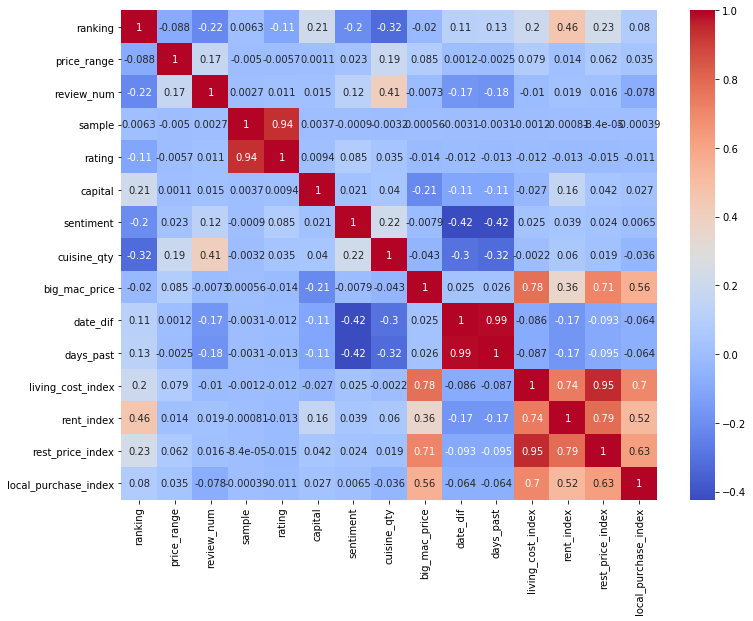

In [433]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

Как видно из матрицы корреляции date_if и days_past имеют практически полную корреляцию, но так как days_past имеет более большую корреляцию с rating, удалим столбец date_dif.

In [434]:
df.drop(['date_dif'], axis=1, inplace=True)

In [435]:
df0 = df[['rating', 'ranking', 'review_num', 'capital', 'sentiment', 'cuisine_qty', 'price_range', 'rent_index', 
         'big_mac_price', 'days_past', 'rest_price_index', 'local_purchase_index', 'living_cost_index', 'sample']]

Посчитаем МАЕ пока только с этими столбцами:

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[4.41  4.915 4.265 ... 4.675 4.275 4.08 ]
MAE: 0.20612


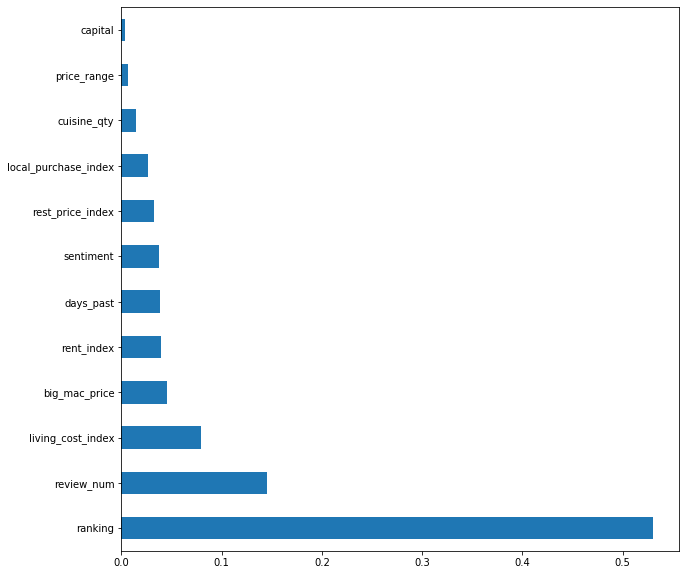

In [436]:
MAE(df0)

### Get_dummies

In [441]:
dummy_city = pd.get_dummies(df.city)
dummy_cuisine = pd.get_dummies(df.cuisine)
dummy_country = pd.get_dummies(df.country)

Посчитаем модель для трех разных вариантов добавления dummies.

#### 1. dummies - city

In [442]:
df_city = pd.concat([df, dummy_city], axis = 1)
df_city.columns

Index(['city', 'cuisine', 'ranking', 'price_range', 'review_num', 'sample',
       'rating', 'country', 'capital', 'sentiment', 'cuisine_qty',
       'big_mac_price', 'days_past', 'living_cost_index', 'rent_index',
       'rest_price_index', 'local_purchase_index', 'Amsterdam', 'Athens',
       'Barcelona', 'Berlin', 'Bratislava', 'Brussels', 'Budapest',
       'Copenhagen', 'Dublin', 'Edinburgh', 'Geneva', 'Hamburg', 'Helsinki',
       'Krakow', 'Lisbon', 'Ljubljana', 'London', 'Luxembourg', 'Lyon',
       'Madrid', 'Milan', 'Munich', 'Oporto', 'Oslo', 'Paris', 'Prague',
       'Rome', 'Stockholm', 'Vienna', 'Warsaw', 'Zurich'],
      dtype='object')

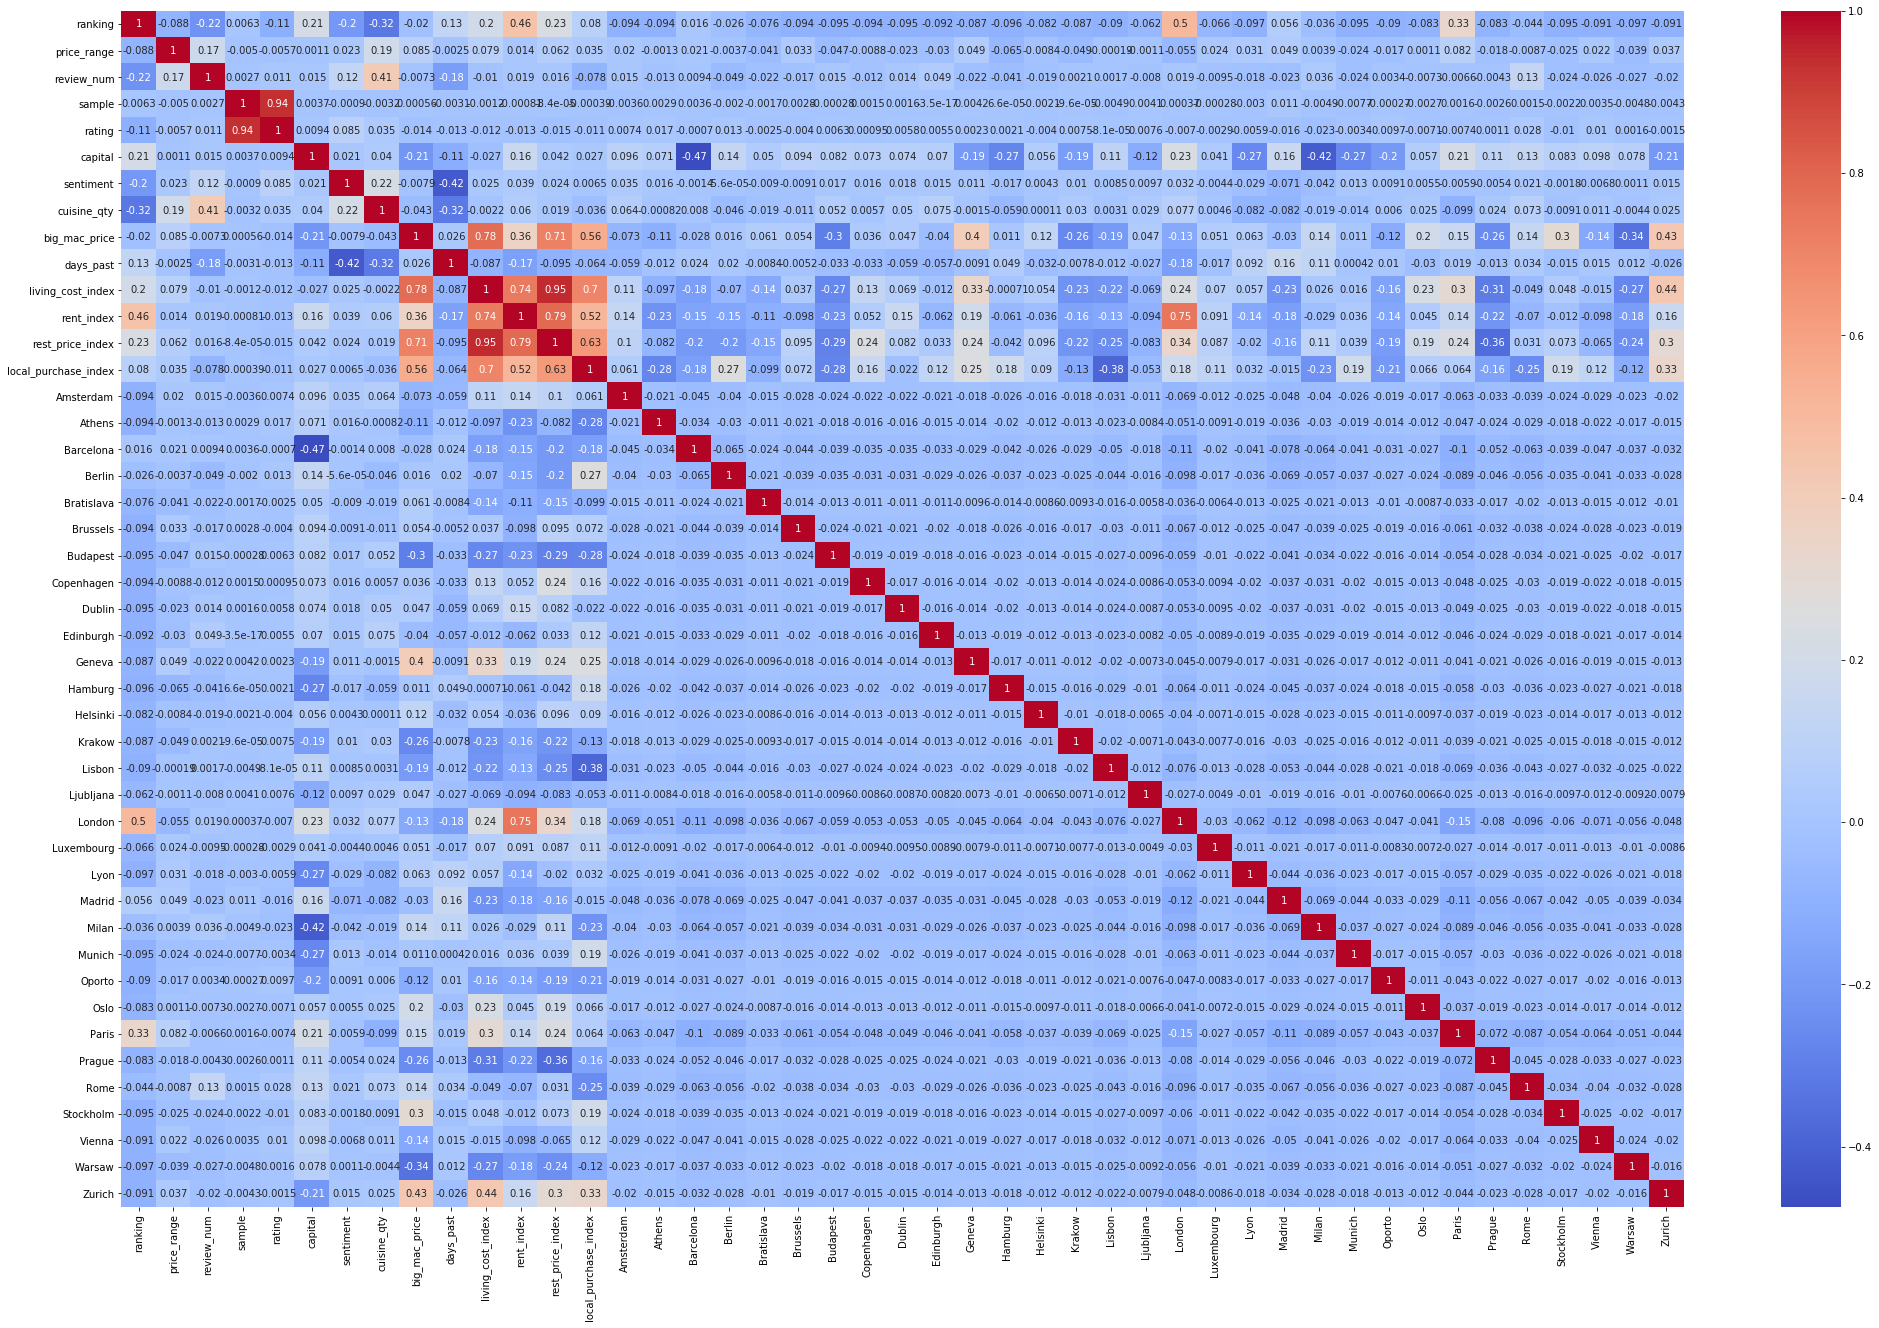

In [443]:
fig, ax = plt.subplots(figsize=(35, 22))
sns.heatmap(df_city.corr(), annot=True, cmap='coolwarm')

In [444]:
df_city.drop(['city', 'cuisine', 'country'], axis=1, inplace=True)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[4.405 4.895 4.225 ... 4.65  4.295 4.07 ]
MAE: 0.20615374999999997


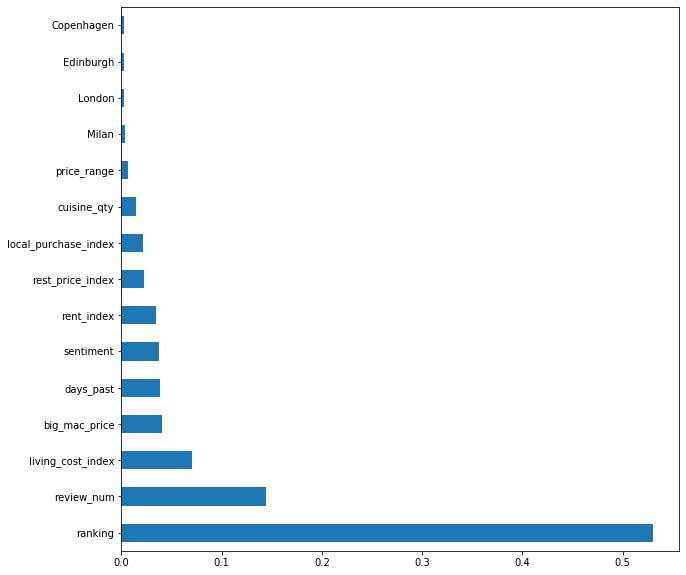

In [445]:
MAE(df_city)

#### 2. dummies - cuisine.

In [446]:
df_cuisine = pd.concat([df, dummy_cuisine], axis = 1)
df_cuisine.columns

Index(['city', 'cuisine', 'ranking', 'price_range', 'review_num', 'sample',
       'rating', 'country', 'capital', 'sentiment',
       ...
       '['Wine Bar', 'Italian']', '['Wine Bar', 'Lebanese']',
       '['Wine Bar', 'Mediterranean', 'European', 'Vegetarian Friendly']',
       '['Wine Bar', 'Mediterranean']',
       '['Wine Bar', 'Scottish', 'Vegetarian Friendly']',
       '['Wine Bar', 'Spanish']', '['Wine Bar', 'Sushi']',
       '['Wine Bar', 'Vegetarian Friendly']', '['Wine Bar', 'Wine Bar']',
       '['Wine Bar']'],
      dtype='object', length=10896)

In [447]:
df_cuisine.drop(['city', 'cuisine', 'country'], axis=1, inplace=True)

Создадим малый датафрейм из большого, оставив всего пятерку типичных cuisine, чтобы посмотреть на корреляцию.

In [448]:
df.cuisine.value_counts().head(5)

['Cafe']                      3001
['Italian']                   2756
['Spanish']                   2324
['French']                    2321
['European', 'Portuguese']     785
Name: cuisine, dtype: int64

In [450]:
df_cuisine_s = df_cuisine[['rating', 'ranking', 'review_num', 'capital', 'sentiment', 'cuisine_qty', 'price_range',
                           'big_mac_price', 'days_past', 'rest_price_index', 'local_purchase_index', 'rent_index', 
                           'living_cost_index', 'sample', "['French']", "['Cafe']", "['Italian']",
                           "['Spanish']", "['European', 'Portuguese']"]]

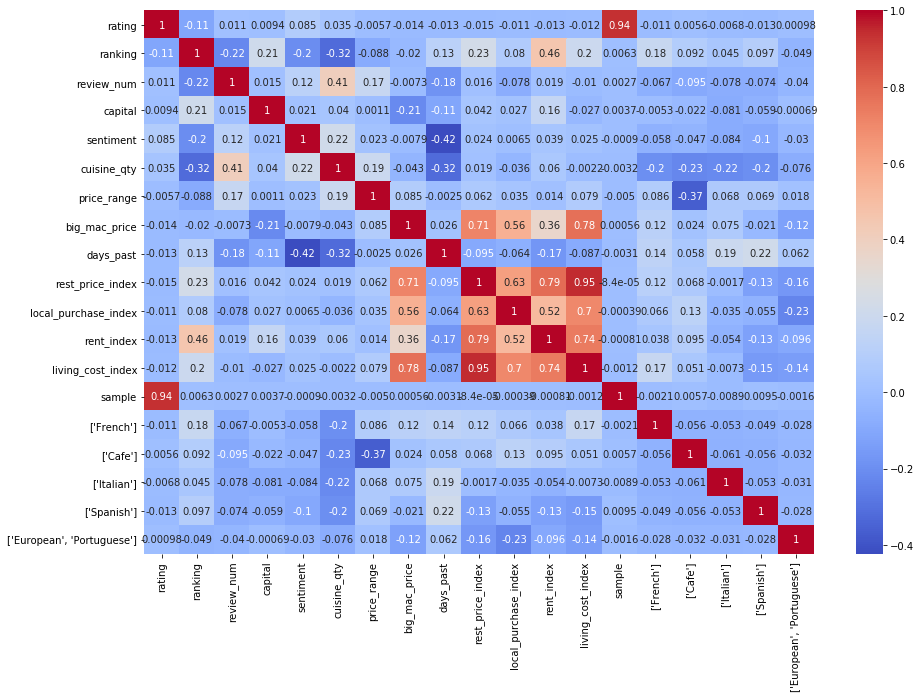

In [451]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_cuisine_s.corr(), annot=True, cmap='coolwarm')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[4.465 4.84  4.335 ... 4.645 4.235 4.045]
MAE: 0.20105249999999997


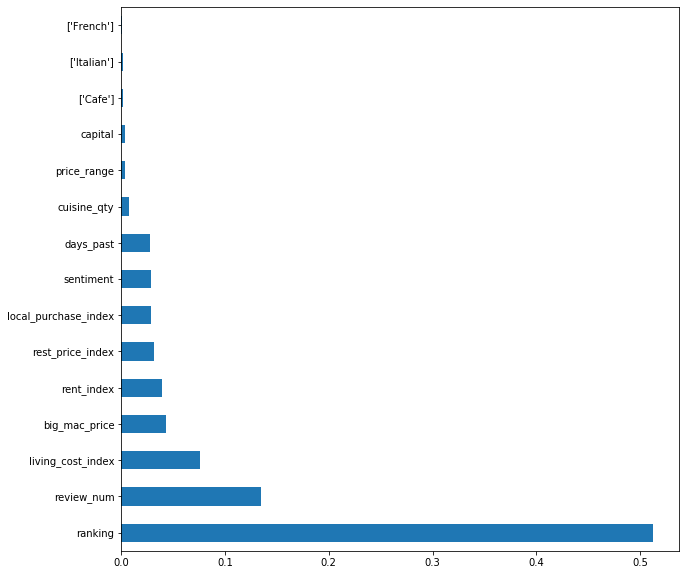

In [452]:
MAE(df_cuisine)

#### 3. dummy - country.

In [453]:
df_country = pd.concat([df, dummy_country], axis = 1)
df_country.columns

Index(['city', 'cuisine', 'ranking', 'price_range', 'review_num', 'sample',
       'rating', 'country', 'capital', 'sentiment', 'cuisine_qty',
       'big_mac_price', 'days_past', 'living_cost_index', 'rent_index',
       'rest_price_index', 'local_purchase_index', 'Austria', 'Belgium',
       'Britain', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany',
       'Greece', 'Hungary', 'Ireland', 'Italy', 'Luxembourg', 'Netherlands',
       'Norway', 'Poland', 'Portugal', 'Scotland', 'Slovakia', 'Slovenia',
       'Spain', 'Sweden', 'Switzerland'],
      dtype='object')

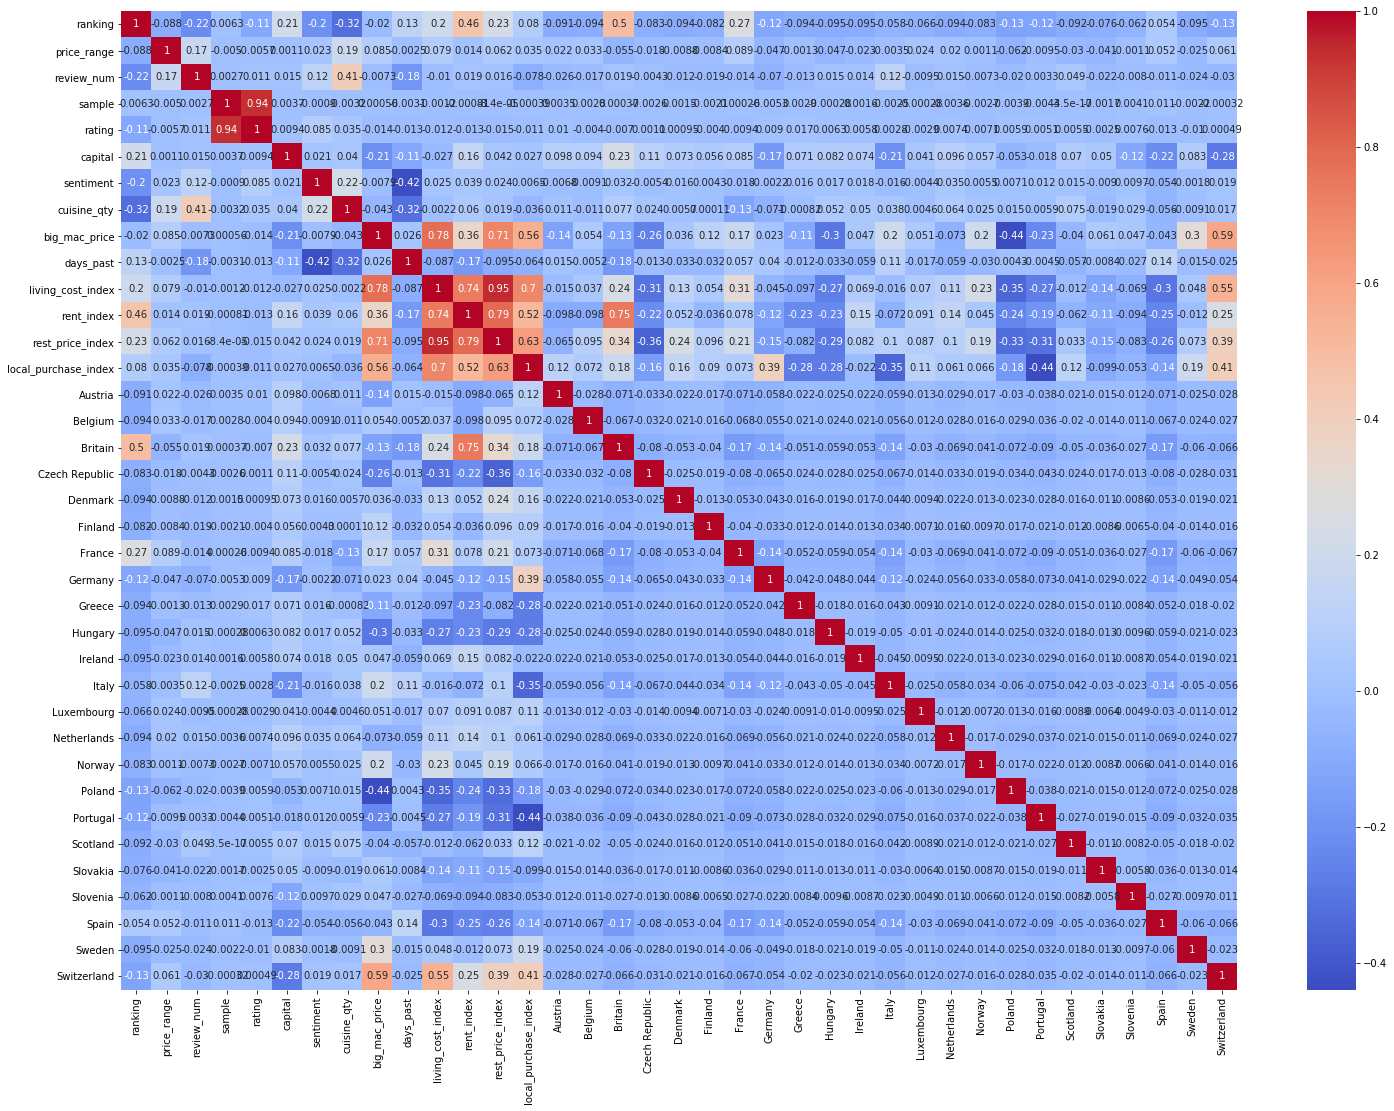

In [454]:
fig, ax = plt.subplots(figsize=(25, 18))
sns.heatmap(df_country.corr(), annot=True, cmap='coolwarm')

In [455]:
df_country.drop(['city', 'cuisine', 'country'], axis=1, inplace=True)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[4.4   4.915 4.265 ... 4.63  4.295 4.07 ]
MAE: 0.20605874999999998


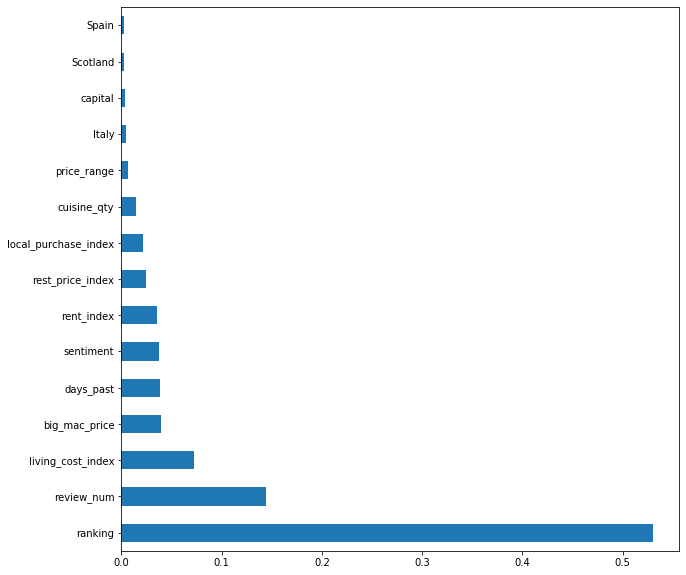

In [456]:
MAE(df_country)

Показатель MAE получается минимальным при dummy_cuisine - 0.201. Оставим датафрейм df_cuisine. И теперь попробуем поудалять отдельно следующие столбцы: price_range, capital (из-за слабой корреляции с rating).

In [457]:
# without price_range
df_cuisine_wo_pr = df_cuisine.drop('price_range', axis = 1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[4.45  4.84  4.34  ... 4.635 4.235 4.045]
MAE: 0.20076249999999995


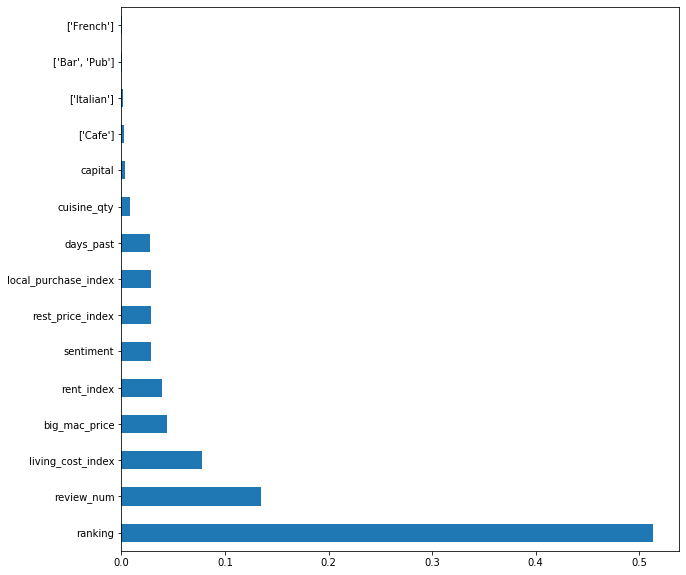

In [458]:
MAE(df_cuisine_wo_pr)

In [463]:
#without capital
df_cuisine_wo_cap = df_cuisine.drop('capital', axis=1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[4.455 4.83  4.31  ... 4.64  4.21  4.04 ]
MAE: 0.20098875


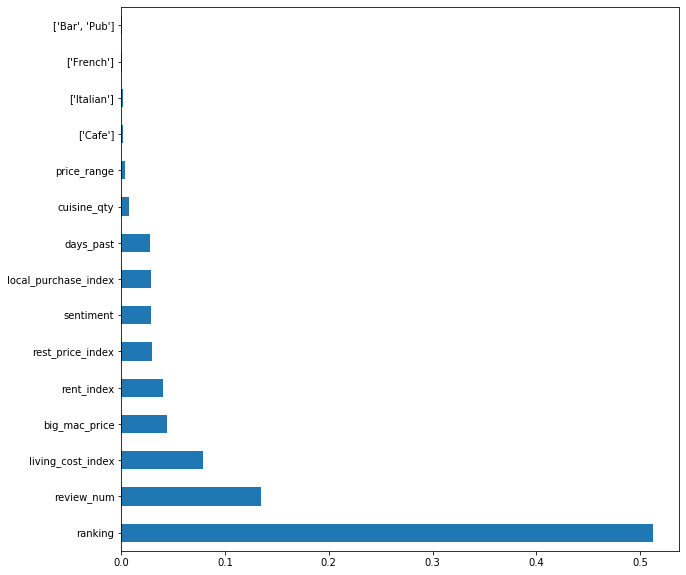

In [464]:
MAE(df_cuisine_wo_cap)

Лучшим вариантом оказался без price_range - 0.20076249.

Теперь посмотрим, как зименится МАЕ, если мы возьмем не только один dummy_cuisine.

#### Dummies - cuisine and country, cuisine and city, cuisine and city and country.

In [467]:
df_cuisine_country = pd.concat([df_cuisine, dummy_country], axis = 1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[4.465 4.825 4.335 ... 4.62  4.215 4.045]
MAE: 0.200859375


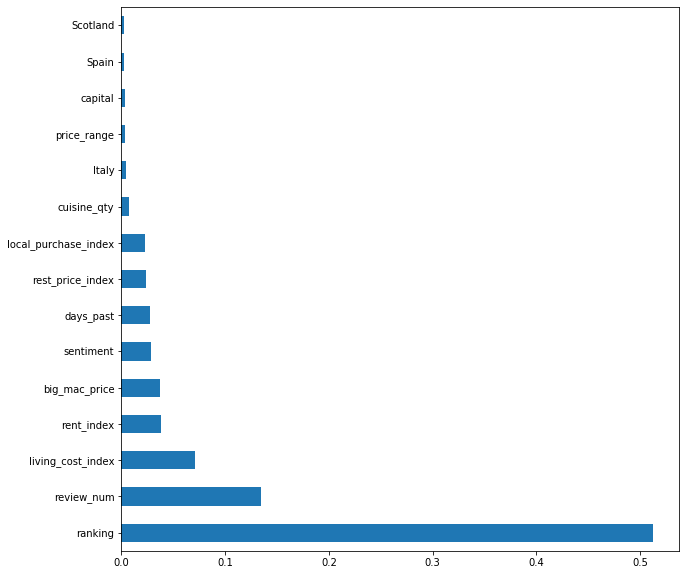

In [470]:
MAE(df_cuisine_country)

In [471]:
df_cuisine_city = pd.concat([df_cuisine, dummy_city], axis = 1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[4.46  4.815 4.345 ... 4.64  4.235 4.05 ]
MAE: 0.20038624999999996


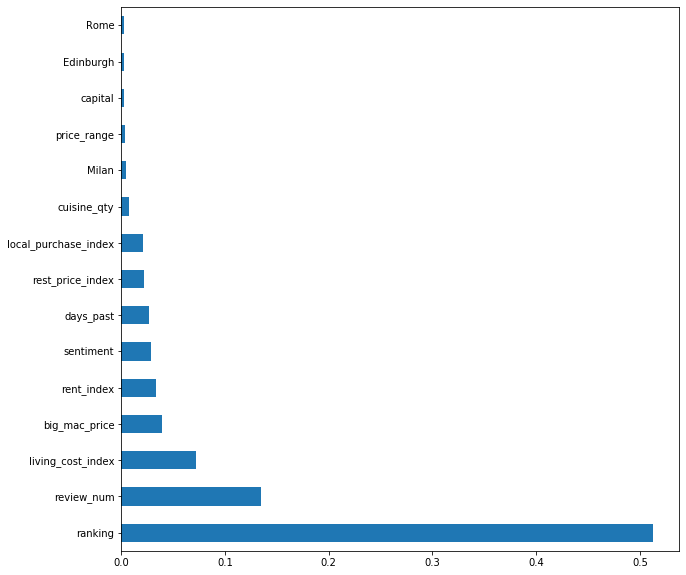

In [472]:
MAE(df_cuisine_city)

In [473]:
df_cuisine_city_country = pd.concat([df_cuisine_country, dummy_city], axis = 1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[4.53  4.845 4.315 ... 4.615 4.225 4.035]
MAE: 0.20031875


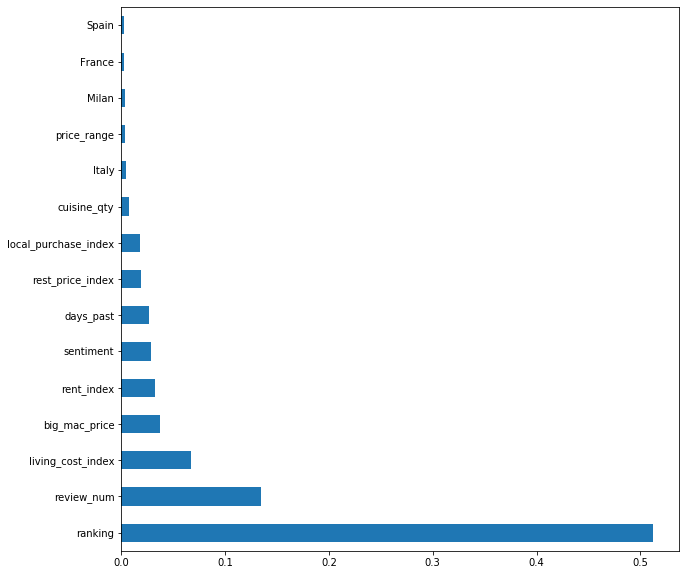

In [474]:
MAE(df_cuisine_city_country)

Из трех вариантов последний самый лучший по МАЕ, оставляем этот датафрейм.

### Итого МАЕ = 0.20031875.